# 1 Aim of the project

The aim is to get the phase profile of a laser beam from an analysis of some intensity images taken at known distances (possibly after a known lens).

# 2 Alternative possibilities

Buy a Shack-Hartmann wavefront sensor or a Phasics wave front sensor  for the right wavelength.
* Shack-Hartmann sensors are sold for __>300 nm__ wavelength for a price of 4'000€ or more (12/2024)
* Phasics sensors are sold for __>400 nm__ wavelength only.

# 3 General considerations for this approach

Only a beam profiling camera is needed (which is anyway present in the lab). However, usually the images do not come from the same laser pulse (which may be a problem), i.e. this method does not provide single shot analysis. The forward problem is treated by Fresnel Diffraction: From an assumed phase profile and a measured intensity profile (at z = 0), one can calulate the intensity profile in any later plane at distance z > 0. 

## 3.1 Assumptions

* All the energy is on all intensity images and no absoprtion takes place in between. 

# 4 Parametrized approaches

The phase profile is modeled using _some_ parameters:
* An ideal thin lens causes a parabolic phase shift.
* A lateral shift of the beam can be understood as the consequence of a linear phase shift (like caused by a prism).
* The abberations in the beam can be modelled by a development into Zernike polynomials.
* The abberations in the beam can be modelled by a development into Fourier components.

## General paramèters and functions

Warning: Set path to access images

In [65]:
import imageio.v3 as iio
import numpy as np
from scipy.optimize import leastsq, minimize, least_squares, basinhopping
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftfreq

# Function to remove the background from the image. Uses the frame of the image.
def remove_bkg(im, rel_frame_width):
    """
    im : 2D np array with image data
    rel_frame_width : float [0, 1] is the fraction of the smaller 
    image side used for defining the background level"""
    if type(im) is not np.ndarray or rel_frame_width < 0 or rel_frame_width > 1:
        print('--> wrong usage of the function remove_bkg')
        return np.nan  # wrong usage of the function
    if im.dtype is not float:
        im = im.astype(float)
    ymax, xmax = im.shape
    small_side = min(ymax, xmax)
    frame_width = int(np.round(small_side * rel_frame_width))
    yfrom = frame_width
    yto = ymax - frame_width
    xfrom = frame_width
    xto = xmax - frame_width
    ma = np.ones(im.shape, dtype=bool)  
    ma[yfrom:yto, xfrom:xto] = np.zeros((yto - yfrom, xto - xfrom), dtype=bool)
    backg = im[ma].mean()
    im = im - backg
    return im

# Function to find the barycenter of the photo
# Return (xc, yc)
def centroid_position(im):
    XX, YY = np.meshgrid(range(im.shape[1]), range(im.shape[0]))
    xc = int(np.round((XX * im).sum() / im.sum()))
    yc = int(np.round((YY * im).sum() / im.sum()))
    return [xc, yc]

# Function that will be used for the propagation of the laser
# Return the transfer function that we use for the Fourier transform method
def aSCH(nux, nuy, z2, la):  # without Fresnel approximation
    return np.exp(2*np.pi*1j * np.sqrt(1/la**2 - nux**2 - nuy**2) * z2)

# Function of laser propagation
# return the signal after popagation to the point(nuX, nuY)
def propag(u1, dz, nuX, nuY, la):
    ft_u1 = fft2(u1)  # puts zero first
    u2 = ifft2(ft_u1 * aSCH(nuX, nuY, dz, la))
    return u2

## Define the functions for the fit
def phase_3p(p, XX, YY):
    """a centered parabola with rotational symmetry:
    p[0] + p[1] * er + p[2] * er**2"""
    center_x = (XX.max() - XX.min())/2 + XX.min()
    # print(f"{center_x = }")
    center_y = (YY.max() - YY.min())/2 + YY.min()
    # print(f"{center_y = }")
    er = np.sqrt( (XX - center_x)**2 + (YY - center_y)**2)
    ph = p[0] + p[1] * er + p[2] * er**2
    return ph

def phase_2p(p, XX, YY):
    """a centered parabola with rotational symmetry:
    p[0] * er + p[1] * er**2"""
    center_x = (XX.max() - XX.min())/2 + XX.min()
    # print(f"{center_x = }")
    center_y = (YY.max() - YY.min())/2 + YY.min()
    # print(f"{center_y = }")
    er = np.sqrt( (XX - center_x)**2 + (YY - center_y)**2)
    ph = p[0] * er + p[1] * er**2
    return ph

def phase_1p(p, XX, YY):
    """a centered parabola with rotational symmetry:
    p[0] * er**2"""
    center_x = (XX.max() - XX.min())/2 + XX.min()
    # print(f"{center_x = }")
    center_y = (YY.max() - YY.min())/2 + YY.min()
    # print(f"{center_y = }")
    er = np.sqrt( (XX - center_x)**2 + (YY - center_y)**2)
    ph = p[0] * er**2
    return ph

def phase_5p(p, XX, YY):
    """a centered parabola with rotational symmetry:
    p[0] + p[1] * er + p[2] * er**2  and 
    p[3] = center_x and p[4] = center_y"""
    center_x = p[3]
    # print(f"{center_x = }")
    center_y = p[4]
    # print(f"{center_y = }")
    er = np.sqrt( (XX - center_x)**2 + (YY - center_y)**2)
    ph = p[0] + p[1] * er + p[2] * er**2
    return ph


## Importing photos
file_name_1 = r"C:\Users\orian\OneDrive\Bureau\Stage 2024-25\Pixel method\Oriane\input_images\foc lent ideale\z0.000_I.tif"  # should contain info on z-position in meters
file_name_2 = r"C:\Users\orian\OneDrive\Bureau\Stage 2024-25\Pixel method\Oriane\input_images\foc lent ideale\z0.150_I.tif"  # should contain info on z-position in meters
file_name_3 = r"C:\Users\orian\OneDrive\Bureau\Stage 2024-25\Pixel method\Oriane\input_images\foc lent ideale\z0.310_I.tif"  # should contain info on z-position in meters
file_name_4 = r"C:\Users\orian\OneDrive\Bureau\Stage 2024-25\Pixel method\Oriane\input_images\foc lent ideale\z0.400_I.tif"  # should contain info on z-position in meters
file_name_0 = r"C:\Users\orian\OneDrive\Bureau\Stage 2024-25\Pixel method\Oriane\input_images\foc lent ideale\z0.000_phi.png"  # the known phase used at for the generation of the images

list_file = [file_name_1, file_name_2, file_name_3, file_name_4]
nb_im = len(list_file)

pisi = 11.71875e-6  # pixel size in meters
la = 1064e-9  # wavelength in meters

# Setting up variables
list_im = []
list_I = []
list_coord_c = []
list_z = []
list_dz = []
for i in range(nb_im):
    list_im += [iio.imread(list_file[i])]
    list_im[i] = remove_bkg(list_im[i], 0.02)
    list_I += [list_im[i] / list_im[i].sum()]
    list_coord_c += [centroid_position(list_im[i])]
    list_z += [list_file[i].split('.tif')[0]]
    list_z[i] = float(list_z[i][-7:-2])
    if i != 0:
        list_dz += [list_z[i] - list_z[0]]

# Displaying important information
for i in range(nb_im):
    print(f"im{i+1} energy = {list_I[i].sum()}")
    print(f" center coordonates im{i+1} xc = {list_coord_c[i][0]}, yc = {list_coord_c[i][1]}")
    print(f"z im{i+1} {list_z[i] = }")    
    if i != 0:
        print(f"distance im1 and im{i+1} {list_dz[i-1] } m")

#in meters
y_extend = (list_I[0].shape[0]-1) * pisi
x_extend = (list_I[0].shape[1]-1) * pisi

y_pts = np.linspace(-y_extend/2, y_extend/2, num=list_I[0].shape[0])
x_pts = np.linspace(-x_extend/2, x_extend/2, num=list_I[0].shape[1])

X, Y = np.meshgrid(x_pts, y_pts)  

## prepare starting field
phi1 = np.zeros(list_I[0].shape)
u1 = np.sqrt(list_I[0]) * np.exp(1j * phi1)

## Prepare propagation
nux = fftfreq(u1.shape[1], pisi)  # puts zero first
nuy = fftfreq(u1.shape[0], pisi)  # puts zero first
nuX, nuY = np.meshgrid(nux, nuy) 

im1 energy = 1.0
 center coordonates im1 xc = 256, yc = 256
z im1 list_z[i] = 0.0
im2 energy = 1.0000000000000002
 center coordonates im2 xc = 256, yc = 256
z im2 list_z[i] = 0.15
distance im1 and im2 0.15 m
im3 energy = 1.0000000000000002
 center coordonates im3 xc = 256, yc = 256
z im3 list_z[i] = 0.31
distance im1 and im3 0.31 m
im4 energy = 0.9999999999999999
 center coordonates im4 xc = 256, yc = 256
z im4 list_z[i] = 0.4
distance im1 and im4 0.4 m


### Intensity

I1 = 8.77589983505165e-05
I2 = 0.00032614766137337717
I3 = 0.007862669924432705
I4 = 0.000853734410645001


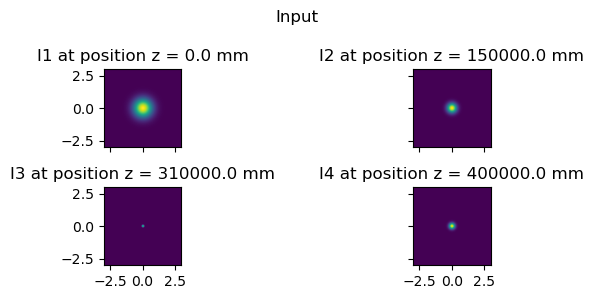

In [2]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                           figsize=(8, 3))
plt.suptitle("Input")
a_labels = np.array([-x_extend/2, x_extend/2, -y_extend/2, y_extend/2])
a_labels = list(a_labels * 1000)  # put axes labels in mm
ax[0][0].set_title(f'I1 at position z = {list_z[0]*1e3:.1f} mm')
ax[0][0].imshow(list_I[0], cmap='viridis', extent=a_labels)
ax[0][1].set_title(f'I2 at position z = {list_z[1]*1e3:.1f} mm')
ax[0][1].imshow(list_I[1], cmap='viridis', extent=a_labels)
ax[1][0].set_title(f'I3 at position z = {list_z[2]*1e3:.1f} mm')
ax[1][0].imshow(list_I[2], cmap='viridis', extent=a_labels)
ax[1][1].set_title(f'I4 at position z = {list_z[3]*1e3:.1f} mm')
ax[1][1].imshow(list_I[3], cmap='viridis', extent=a_labels)
fig.tight_layout()
for i in range(nb_im):
    print(f"I{i+1} = {list_I[i].max()}")

## Which function works best for the fit of the lens phase?

For now we only use one image after the lens to make the fit

#### Prepares the research phase to the lens


In [3]:
mod_phase = phase_2p

if mod_phase == phase_3p :
    guess_vals = [0, 0, 0]
elif mod_phase == phase_1p :
    guess_vals = [0]
elif mod_phase == phase_2p :
    guess_vals = [0, 0]
else :
    guess_vals = [0, 0, 0, 0.0005, -0.0005]


### Fit with leastsq

In [ ]:
# Change the fit models by changing phase to phase2 or phase3 and adapting the parameters in guess_vals
def residuals(pars, sqrtI1, X_mat, Y_mat, I2_measured, dz): 
    """The difference between simulated ans measured intensity"""
    u1_assumed = sqrtI1 * np.exp(1j * mod_phase(pars, X_mat, Y_mat))
    u2_simulated =propag(u1_assumed, dz, nuX, nuY, la)
    return (np.abs(u2_simulated)**2 - I2_measured).flatten()

list_fpars = []
for i in range(nb_im-1):
    fpars,_, infodict, errmsg2D, success2D = leastsq(residuals, 
        guess_vals, args=(u1, X, Y, list_I[i+1], list_dz[i]), full_output=True, 
        epsfcn=0.0001)
    if success2D not in [1, 2, 3, 4]:  # If success is equal to 1, 2, 3 or 4, the solution was found.
        print(errmsg2D)
    else:
        print(fpars)
        list_fpars += [fpars]
        print(f" Number of iterations : {infodict['nfev']}")

[-1.55073504e-01 -9.52465042e+06]
 Nombre d'itération : 36
[ 4.45704394e+02 -9.74506931e+06]
 Nombre d'itération : 62
[-1.86239937e+00 -5.23847075e+06]
 Nombre d'itération : 40


### Fit with minimize 

#### Powell methode

In [37]:
def costs(pars, arg): 
    """The difference between simulated ans measured intensity"""
    sqrtI1, X_mat, Y_mat, I_measured, dz = arg[0], arg[1], arg[2], arg[3], arg[4]
    u1_assumed = sqrtI1 * np.exp(1j * mod_phase(pars, X_mat, Y_mat))
    u2_simulated =propag(u1_assumed, dz, nuX, nuY, la)  
    return np.abs((u2_simulated)**2 - I_measured).sum() 

list_fpars = []
for i in range(nb_im-1):
    result = minimize(costs, guess_vals, [u1, X, Y, list_I[i+1], list_dz[i]], method="Powell")
    fpars = result.x
    success2D = result.success
    errmsg2D = result.message
    if success2D != True :  
        print(errmsg2D)
    else:
        print(fpars)
        list_fpars += [fpars]

[ 2.65198542e+03 -3.77545806e+06]
[-2.53072767e+03 -8.06298218e+06]
[ 2.17586253e+02 -9.65870155e+06]


#### Nelson-Mead methode

In [38]:
list_fpars = []
for i in range(nb_im-1):
    result = minimize(costs, guess_vals, [u1, X, Y, list_I[i+1], list_dz[i]], method="Nelder-Mead")
    fpars = result.x
    success2D = result.success
    errmsg2D = result.message
    if success2D != True :  
        print(errmsg2D)
    else:
        print(fpars)
        list_fpars += [fpars]

[ 2.65244137e+03 -3.77633155e+06]
[ 6.48923715e+03 -1.34310086e+07]
[ 9.87406339e+03 -1.57973516e+07]


### Fit with least_squares

#### lm methode (same as leastsq methode)

In [39]:
list_fpars = []
for i in range(nb_im-1):
    result = least_squares(residuals, guess_vals, args=(u1, X, Y, list_I[i+1], list_dz[i]),
                       method='lm', verbose=0)
    if success2D != True :  # If success is equal to 1, 2, 3 or 4, the solution was found.
        print(errmsg2D)
    else:
        print(fpars)
        list_fpars += [fpars]

[ 9.87406339e+03 -1.57973516e+07]
[ 9.87406339e+03 -1.57973516e+07]
[ 9.87406339e+03 -1.57973516e+07]


#### trf methode

In [40]:
list_fpars = []
for i in range(nb_im-1):
    result = least_squares(residuals, guess_vals, args=(u1, X, Y, list_I[i+1], list_dz[i]),
                       method='trf', verbose=0)
    if success2D != True :  # If success is equal to 1, 2, 3 or 4, the solution was found.
        print(errmsg2D)
    else:
        print(fpars)
        list_fpars += [fpars]

[ 9.87406339e+03 -1.57973516e+07]
[ 9.87406339e+03 -1.57973516e+07]
[ 9.87406339e+03 -1.57973516e+07]


#### Méthode dogbox

In [41]:
list_fpars = []
for i in range(nb_im-1):
    result = least_squares(residuals, guess_vals, args=(u1, X, Y, list_I[i+1], list_dz[i]),
                       method='dogbox', verbose=0)
    if success2D != True :  # If success is equal to 1, 2, 3 or 4, the solution was found.
        print(errmsg2D)
    else:
        print(fpars)
        list_fpars += [fpars]

[ 9.87406339e+03 -1.57973516e+07]
[ 9.87406339e+03 -1.57973516e+07]
[ 9.87406339e+03 -1.57973516e+07]


### Fit with basinhooping

In [42]:
def residuals(pars, sqrtI1, X_mat, Y_mat, I2_measured, dz): 
    """The difference between simulated ans measured intensity"""
    u1_assumed = sqrtI1 * np.exp(1j * mod_phase(pars, X_mat, Y_mat))
    u2_simulated =propag(u1_assumed, dz, nuX, nuY, la)
    return (np.abs(u2_simulated)**2 - I2_measured).sum()

list_fpars = []
for i in range(nb_im-1):
    result = basinhopping(residuals, guess_vals, minimizer_kwargs={'args':(u1, X, Y, list_I[i+1], list_dz[i])})
    if success2D != True : 
       print(errmsg2D)
    else:
        print(fpars)
        list_fpars += [fpars]

[ 9.87406339e+03 -1.57973516e+07]
[ 9.87406339e+03 -1.57973516e+07]
[ 9.87406339e+03 -1.57973516e+07]


## Fits Results Comparison Table


This table was constructed with the values of quadratic parameters found by different methods in case we were looking for a phase with only 2 parameters.

methode used| Quadratic parameters (image1; image2; image3) | time | Average Spread 
 --- | --- | --- | ---
leastsq | -9,51415729e+06; -9,74506931e+06; -5,23847075e+06 | 12.0s | 1,58E-01
least_square lm | -1,57973516e+07; -1,57973516e+07; -1,57973516e+07 | 57.8s | 6,59E-01
least_square trf | -1,57973516e+07; -1,57973516e+07; -1,57973516e+07 | 8.8s | 6,59E-01
least_square dogbox | -1,57973516e+07; -1,57973516e+07; -1,57973516e+07 | 8.7 | 6,59E-01
minimize Powell | -3,74304117e+06; -8,06298218e+06; -9,65870155e+06 | 42.0s | 2,58E-01
minimize Nelder-Mead | -3,74449021e+06; -1,34310086e+07; -1,57973516e+07 | 1min 24.4s | 5,59E-01
basinhooping | -1,57973516e+07; -1,57973516e+07; -1,57973516e+07 | 1min 8.0s | 6,59E-01

We deduce that in our case it is better to use the method leastsq.

## With 2 images 

The leastsq method is therefore the quickest and gives results closest to reality.

Add the modeling of the case where the image of the beam is not in the center of the camera with the function offset_center, then correct this off-centre with the recenter function.

### Implementation 

Some change must be made to the variable setting relative to the case of an image, since we want to be able to work on images that are not centered.

In [ ]:
def décalage_centre(i, xpos=0, xneg=0, ypos=0, yneg=0):
    if xneg != 0:
        #Création du décalage selon y sur l'image 2 centre_im < centre_xy
        list_im[i] = np.vstack((list_im[i][xneg:], list_im[i][:xneg]))
    if xpos != 0:
        #Création du décalage selon y sur l'image 2 centre_im > centre_xy
        list_im[i] = np.vstack((list_im[i][-xpos:], list_im[i][:-xpos]))
    if yneg != 0:
        #Création du décalage selon x sur l'image 2 centre_im < centre_xy
        list_im[i] = np.hstack((list_im[i][:,yneg:], list_im[i][:,:yneg]))
    if ypos != 0:   
        #Création du décalage selon x sur l'image 2 centre_im < centre_xy
        list_im[i] = np.hstack((list_im[i][:,-ypos:], list_im[i][:,:-ypos]))

list_I = []
list_coord_c = []
for i in range(nb_im):
    if i == 0:
        décalage_centre(0)
    if i == 1:
        décalage_centre(1, xpos=300, ypos=289)
        décalage_centre(1)
    if i == 2:
        décalage_centre(2, xneg=30, yneg=400)
    if i == 3:
        décalage_centre(3)
    list_I += [list_im[i] / list_im[i].sum()]
    list_coord_c += [centroid_position(list_im[i])]

for i in range(nb_im):
    print(f"im{i+1} energy = {list_I[i].sum()}")
    print(f"coordonnées centre im{i+1} xc = {list_coord_c[i][0]}, yc = {list_coord_c[i][1]}")
    print(f"z im{i+1} {list_z[i] = }")    
    if i != 0:
        print(f"distance im1 et im{i+1} {list_dz[i-1] } m")

def recentrage(im, i) :
    if list_coord_c[i][0] != len(x_pts)//2 : 
        dist_centres = np.abs(list_coord_c[i][0] - len(x_pts)//2)
        if list_coord_c[i][0] < len(x_pts)//2 : 
            im = np.hstack((im[:, -dist_centres:], im[:, :-dist_centres]))
            list_coord_c[i][0] = centroid_position(im)[0]
            list_I[i]=im
            return recentrage(im, i)
        if list_coord_c[i][0] > len(x_pts)//2 : 
            im = np.hstack((im[:, dist_centres:], im[:, :dist_centres]))
            list_coord_c[i][0] = centroid_position(im)[0]
            list_I[i]=im
            return recentrage(im, i)

    if list_coord_c[i][1] != len(y_pts)//2 : 
        dist_centres = np.abs(list_coord_c[i][1] - len(y_pts)//2)
        if list_coord_c[i][1] < len(x_pts)//2 :
            im = np.vstack((im[-dist_centres:], im[:-dist_centres]))
            list_coord_c[i][1] = centroid_position(im)[1]
            list_I[i]=im
            return recentrage(im, i)
        if list_coord_c[i][1] > len(x_pts)//2 :
            im = np.vstack((im[dist_centres:], im[:dist_centres]))
            list_coord_c[i][1] = centroid_position(im)[1]
            list_I[i]=im
            return recentrage(im, i)
    if list_coord_c[i] == [len(x_pts)//2, len(y_pts)//2]:
        return True

for i in range(len(list_I)):
    while recentrage(list_I[i], i) != True:
        recentrage(list_I[i], i)

im1 energy = 1.0
coordonnées centre im1 xc = 256, yc = 256
z im1 list_z[i] = 0.0
im2 energy = 0.9999999999999999
coordonnées centre im2 xc = 67, yc = 55
z im2 list_z[i] = 0.15
distance im1 et im2 0.15 m
im3 energy = 0.9999999999999999
coordonnées centre im3 xc = 368, yc = 226
z im3 list_z[i] = 0.31
distance im1 et im3 0.31 m
im4 energy = 0.9999999999999999
coordonnées centre im4 xc = 256, yc = 256
z im4 list_z[i] = 0.4
distance im1 et im4 0.4 m


### Fit of the phase

In [66]:
mod_phase = phase_2p
im_et = [2, 4]

def residuals_2im(pars, sqrtI1, X_mat, Y_mat, I2_measured, I3_measured):  
    """The difference between simulated ans measured intensity"""
    u1_assumed = sqrtI1 * np.exp(1j * mod_phase(pars, X_mat, Y_mat))
    u2_simulated =propag(u1_assumed, list_dz[im_et[0]-2], nuX, nuY, la)  
    u3_simulated =propag(u1_assumed, list_dz[im_et[1]-2], nuX, nuY, la) 
    debut_array = I2_measured - np.abs(u2_simulated)**2 
    fin_array = I3_measured - np.abs(u3_simulated)**2 
    return np.vstack((debut_array, fin_array)).flatten()

if mod_phase == phase_3p :
    guess_vals = [0,0,0]
elif mod_phase == phase_1p :
    guess_vals = [0]
elif mod_phase == phase_2p :
    guess_vals = [0,0]
else :
    guess_vals = [0,0,0,0.0005,-0.0005]

fpars,_, infodict, errmsg2D, success2D = leastsq(residuals_2im, 
    guess_vals, args=(u1, X, Y, list_I[im_et[0]-1], list_I[im_et[1]-1]), full_output=True, 
    epsfcn=0.0001)
if success2D not in [1, 2, 3, 4]: 
    print(errmsg2D)
else:
    print(fpars)
    print(f" Number of iterations : {infodict['nfev']}")



[-1.39110998e+03 -4.16971180e+06]
 Number of iterations : 36


### Display of 2D phase passing through the center of the image (refocused)

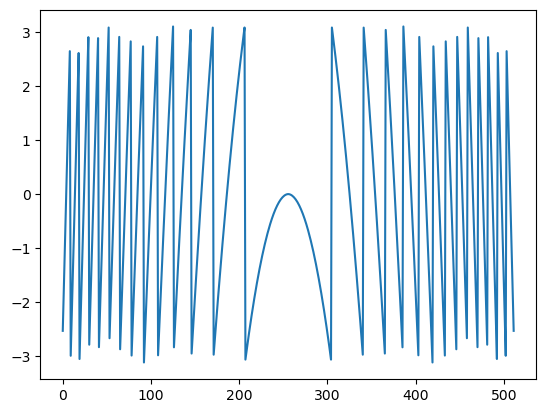

In [45]:

mod_p = (mod_phase(fpars, X, Y)- mod_phase(fpars, X, Y)[256, 256])
phase_milieu = np.angle(np.exp(1j * mod_p))[256]
plt.plot(phase_milieu)


### Graphic comparison of phase to lens by fit and real

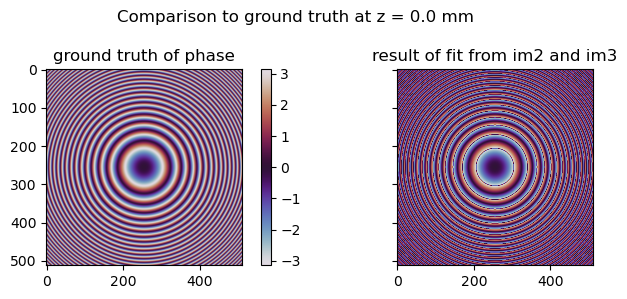

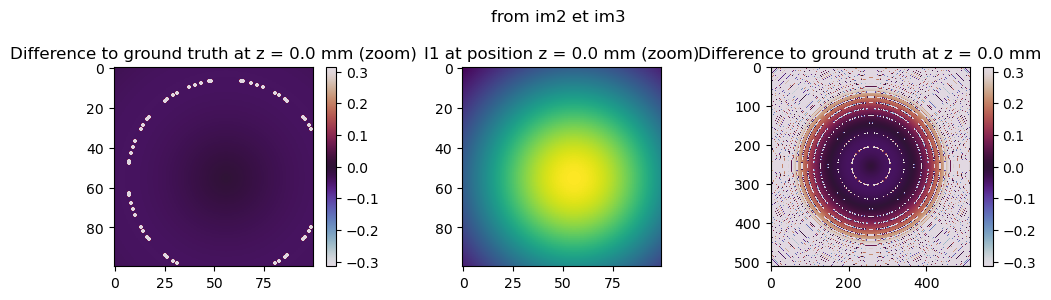

In [52]:
## compare result to input used for simulation of I2_image
phi1_im = iio.imread(file_name_0)

fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                           figsize=(8, 3))
plt.suptitle(f"Comparison to ground truth at z = {list_z[0]*1e3:.1f} mm")

ax[0].set_title(f'ground truth of phase')
ax[0].imshow(phi1_im)

ax[1].set_title(f'result of fit from im{im_et[0]} and im{im_et[1]}')
if mod_phase == phase_5p:
    center_x = fpars[-2]
    center_y = fpars[-1]
    inter_x = np.absolute(X[0]-center_x)
    inter_y = np.absolute(Y[:,0]-center_y)
    pos_cent_x = int(inter_x.argmin())
    pos_cent_y = int(inter_y.argmin())
else:
    pos_cent_x = int(X.shape[1]/2)
    pos_cent_y = int(X.shape[0]/2)
        
mod_p = (mod_phase(fpars, X, Y) - mod_phase(fpars, X, Y)[pos_cent_x][pos_cent_y])
phi_trouver = np.angle(np.exp(1j * mod_p))

cax = ax[1].imshow(phi_trouver, cmap='twilight', 
                   vmin=-np.pi, vmax=np.pi)

fig.colorbar(cax, ax=ax[0])
fig.tight_layout()

def phase_perfect(rlens):
    return 9524595.723956442 * rlens**2

#phase create by the lens based on manufacturer data
phi_known = -np.angle(np.exp(1j * phase_perfect(np.sqrt(X**2 + Y**2)))) # why this sign correction?

idx_small = 200
idx_large = 300

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
plt.suptitle(f'from im{im_et[0]} et im{im_et[1]}')
ax[0].set_title(f'Difference to ground truth at z = {list_z[0]*1e3:.1f} mm (zoom)')
cax = ax[0].imshow((phi_known[idx_small:idx_large,idx_small:idx_large] - 
                    phi_trouver[idx_small:idx_large,idx_small:idx_large]), 
                    cmap='twilight', vmin=-np.pi/10, vmax=np.pi/10)
fig.colorbar(cax, ax=ax[0])
ax[1].set_title(f'I1 at position z = {list_z[0]*1e3:.1f} mm (zoom)')
ax[1].imshow(list_I[0][idx_small:idx_large,idx_small:idx_large], 
            cmap='viridis')
ax[2].set_title(f'Difference to ground truth at z = {list_z[0]*1e3:.1f} mm')
cax = ax[2].imshow((phi_known - phi_trouver), 
                    cmap='twilight', vmin=-np.pi/10, vmax=np.pi/10)
fig.colorbar(cax, ax=ax[2])
fig.tight_layout()




### Table comparing quadratic parameters based on allowed parameters and used images.

model | Images used | Quadratics parameters | Relative Gap
--- | --- | --- | ---
1 parameter | 2 and 3 | -9527157 | 2,69E-04
1 parameter | 3 and 4 | -9523896 | 7,35E-05
1 parameter | 2 and 4 | -9523171 | 1,50E-04
2 parameters | 2 and 3 | -9558774,53 | 3,59E-03
2 parameters | 3 and 4 | -9564972,78 | 4,24E-03
2 parameters | 2 and 4 | -4171876,23 | 5,62E-01
3 parameters | 2 and 3 | -9285553,09 | 2,51E-02
3 parameters | 3 and 4 | -9944274,25 | 4,41E-02
3 parameters | 2 and 4 | 149366,649 | 1,02E+00
5 parameters | 2 and 3 | -9447414 | 8,10E-03
5 parameters | 3 and 4 | -9534811,59 | 1,07E-03
5 parameters | 2 and 4 | -4202657,79 | 5,59E-01

Table of relative averages

Model | mean relative deviations
--- | ---
1 parameters | 0,000163986
2 parameters | 0,190014708
3 parameters | 0,361614072
5 parameters | 0,189311115


### Display qi2 case to 2 parameters

Be careful before relaunching check above that it corresponds well to the case of the 2-parameter parable.

Use of logarithmic normalization for the color scale.


#### For images 2 and 3 

The white point corresponds to the parameters return by the function leastsq

Text(0, 0.5, 'Axe des b dans : a*er + b*er**2')

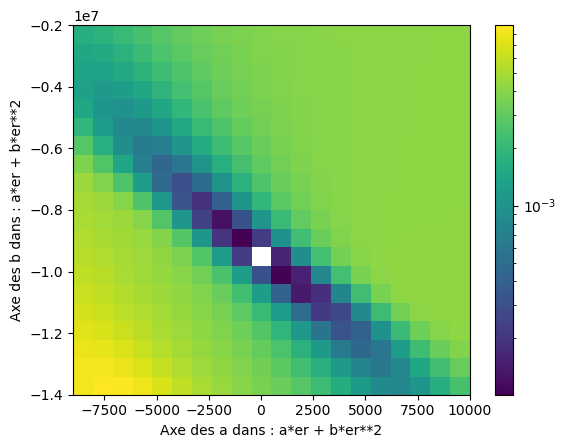

In [ ]:
x_qi = np.linspace(-9e3,10e3,20) #linear parameter,a : a*er + b*er**2
y_qi = np.linspace(-14e6, -2e6, 20) #quadratic parameter,b : a*er + b*er**2
X_qi, Y_qi = np.meshgrid(x_qi, y_qi) 

Qi_c = np.zeros((np.size(y_qi), np.size(x_qi)))
for x in range(np.size(x_qi)):
    for y in range(np.size(y_qi)):
        Qi_c[y, x] = (residuals_2im(np.array([x_qi[x], y_qi[y]]), u1, X, Y, list_I[im_et[0]-1], list_I[im_et[1]-1])**2).sum()

inter_x_Qi = np.absolute(x_qi-(-7.41808060e+01))
inter_y_Qi = np.absolute(y_qi-(-9.36933695e+06))
pos_x_Qi = int(inter_x_Qi.argmin())
pos_y_Qi = int(inter_y_Qi.argmin())
Qi_c[pos_y_Qi, pos_x_Qi] = 0

fig, ax = plt.subplots()

img = ax.imshow(Qi_c, cmap='viridis', norm='log' ,extent=[x_qi[0], x_qi[-1], y_qi[0], y_qi[-1]], aspect='auto', origin='lower')
fig.colorbar(img)
plt.xlabel('Linear parameter,a : a*er + b*er**2')
plt.ylabel('Quadratic parameter,b : a*er + b*er**2')

#### For images 3 and 4

The white point corresponds to the parameters return by the function leastsq

Text(0, 0.5, 'Axe des b dans : a*er + b*er**2')

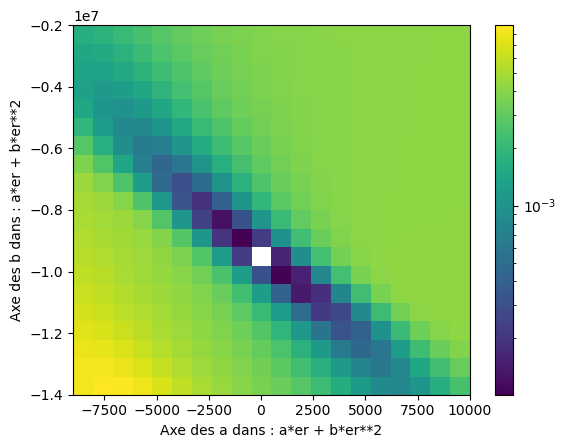

In [ ]:
x_qi = np.linspace(-9e3,10e3,20) 
y_qi = np.linspace(-14e6, -2e6, 20) 
X_qi, Y_qi = np.meshgrid(x_qi, y_qi) 

Qi_c = np.zeros((np.size(y_qi), np.size(x_qi)))
for x in range(np.size(x_qi)):
    for y in range(np.size(y_qi)):
        Qi_c[y, x] = (residuals_2im(np.array([x_qi[x], y_qi[y]]), u1, X, Y, list_I[im_et[0]-1], list_I[im_et[1]-1])**2).sum()

inter_x_Qi = np.absolute(x_qi-(-3.19190587e+02))
inter_y_Qi = np.absolute(y_qi-(-9.26862211e+06))
pos_x_Qi = int(inter_x_Qi.argmin())
pos_y_Qi = int(inter_y_Qi.argmin())
Qi_c[pos_y_Qi, pos_x_Qi] = 0

fig, ax = plt.subplots()

img = ax.imshow(Qi_c, cmap='viridis', norm='log' ,extent=[x_qi[0], x_qi[-1], y_qi[0], y_qi[-1]], aspect='auto', origin='lower')
fig.colorbar(img)
plt.xlabel('Linear parameter,a : a*er + b*er**2')
plt.ylabel('Quadratic parameter,b : a*er + b*er**2')

#### For images 2 and 4

The white point corresponds to the parameters return by the function leastsq

Text(0, 0.5, 'Axe des b dans : a*er + b*er**2')

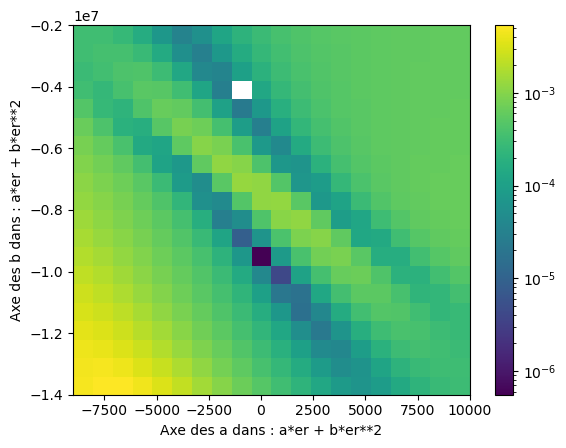

In [ ]:
x_qi = np.linspace(-9e3,10e3,20) 
y_qi = np.linspace(-14e6, -2e6, 20) 
X_qi, Y_qi = np.meshgrid(x_qi, y_qi) 

Qi_c = np.zeros((np.size(y_qi), np.size(x_qi)))
for x in range(np.size(x_qi)):
    for y in range(np.size(y_qi)):
        Qi_c[y, x] = (residuals_2im(np.array([x_qi[x], y_qi[y]]), u1, X, Y, list_I[im_et[0]-1], list_I[im_et[1]-1])**2).sum()

inter_x_Qi = np.absolute(x_qi-(-1.38833202e+03))
inter_y_Qi = np.absolute(y_qi-(-4.17187623e+06))
pos_x_Qi = int(inter_x_Qi.argmin())
pos_y_Qi = int(inter_y_Qi.argmin())
Qi_c[pos_y_Qi, pos_x_Qi] = 0

fig, ax = plt.subplots()

img = ax.imshow(Qi_c, cmap='viridis', norm='log' ,extent=[x_qi[0], x_qi[-1], y_qi[0], y_qi[-1]], aspect='auto', origin='lower')
fig.colorbar(img)
plt.xlabel('Linear parameter,a : a*er + b*er**2')
plt.ylabel('Quadratic parameter,b : a*er + b*er**2')

We can see that when we use the images 2 and 4 to make our fit, a wrong parameter is found because in the parametric space we have two possible solutions.

It is concluded that to make a good estimate of the phase we need only two images: one made at the focal plane image of the lens and one made before the focal point.

## With 3 images

### fit of the phase

In [ ]:
def residuals_3im(pars, sqrtI1, X_mat, Y_mat, I2_measured, I3_measured, I4_measured):  # one could also pass modelfct
    """The difference between simulated ans measured intensity"""
    u1_assumed = sqrtI1 * np.exp(1j * mod_phase(pars, X_mat, Y_mat))
    u2_simulated =propag(u1_assumed, list_dz[0], nuX, nuY, la)  
    u3_simulated =propag(u1_assumed, list_dz[1], nuX, nuY, la)
    u4_simulated =propag(u1_assumed, list_dz[2], nuX, nuY, la) 
    debut_array = np.abs(u2_simulated)**2 - I2_measured
    milieu_array = np.abs(u3_simulated)**2 - I3_measured
    fin_array = np.abs(u4_simulated)**2 - I4_measured
    return np.vstack((debut_array, milieu_array, fin_array)).flatten()

fpars,_, infodict, errmsg2D, success2D = leastsq(residuals_3im, 
    guess_vals, args=(u1, X, Y, list_I[1], list_I[2], list_I[3]), full_output=True, 
    epsfcn=0.0001)
if success2D not in [1, 2, 3, 4]:  # If success is equal to 1, 2, 3 or 4, the solution was found.
    print(errmsg2D)
else:
    print(fpars)
    print(f" Number of iterations : {infodict['nfev']}")

[ 1.38898829e+02 -9.63830763e+06]
 Nombre d'itération : 48


### Comparaison graphique de la phase à la lentille

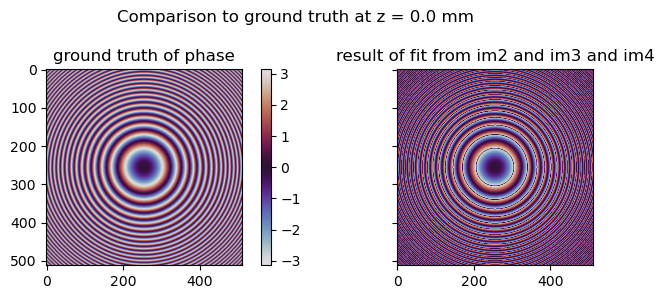

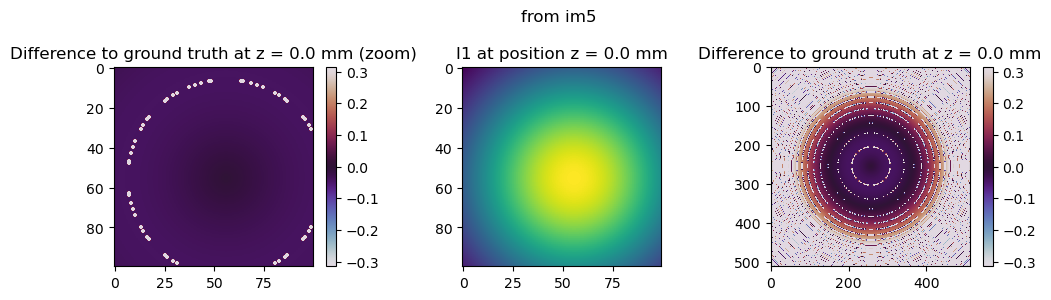

In [ ]:
phi1_im = iio.imread(file_name_0)


fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                           figsize=(8, 3))
plt.suptitle(f"Comparison to ground truth at z = {list_z[0]*1e3:.1f} mm")
ax[0].set_title(f'ground truth of phase')
ax[0].imshow(phi1_im)
ax[1].set_title(f'result of fit from im2 and im3 and im4')

if mod_phase == phase_5p:
    center_x = fpars[-2]
    center_y = fpars[-1]
    inter_x = np.absolute(X[0]-center_x)
    inter_y = np.absolute(Y[:,0]-center_y)
    pos_cent_x = int(inter_x.argmin())
    pos_cent_y = int(inter_y.argmin())
else:
    pos_cent_x = int(X.shape[1]/2)
    pos_cent_y = int(X.shape[0]/2)
        
mod_p = (mod_phase(fpars, X, Y) - mod_phase(fpars, X, Y)[pos_cent_x][pos_cent_y])

phi_trouver = np.angle(np.exp(1j * mod_p))
cax = ax[1].imshow(phi_trouver, cmap='twilight', 
                   vmin=-np.pi, vmax=np.pi)
fig.colorbar(cax, ax=ax[0])
fig.tight_layout()

def phase_perfect(rlens):
    return 9524595.723956442 * rlens**2

#phase create by the lens based on manufacturer data
phi_known = -np.angle(np.exp(1j * phase_perfect(np.sqrt(X**2 + Y**2)))) # why this sign correction?

idx_small = 200
idx_large = 300

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
plt.suptitle(f'from im{i+2}')
ax[0].set_title(f'Difference to ground truth at z = {list_z[0]*1e3:.1f} mm (zoom)')
cax = ax[0].imshow((phi_known[idx_small:idx_large,idx_small:idx_large] - 
                    phi_trouver[idx_small:idx_large,idx_small:idx_large]), 
                    cmap='twilight', vmin=-np.pi/10, vmax=np.pi/10)
fig.colorbar(cax, ax=ax[0])
ax[1].set_title(f'I1 at position z = {list_z[0]*1e3:.1f} mm')
ax[1].imshow(list_I[0][idx_small:idx_large,idx_small:idx_large], 
            cmap='viridis')
ax[2].set_title(f'Difference to ground truth at z = {list_z[0]*1e3:.1f} mm')
cax = ax[2].imshow((phi_known - phi_trouver), 
                    cmap='twilight', vmin=-np.pi/10, vmax=np.pi/10)
fig.colorbar(cax, ax=ax[2])
fig.tight_layout()


# 5 Pixelized approaches

Work based on previous intern Carolina’s code

## Image used

Quantel Q-smart, 2018 03 22
Focale : 750mm
IR 10Hz salle100Hz

Two directories -10 and +5. Only images without too much background are in the directories.

Background is mesured in the lower left corner : ul=(391; 246), rl=(501; 500)
 

### Propagation 

There are different ways to propagate the laser beam from one cross-section to another. The most common one is the Fresnel propagation algorithm, based on the Huygens-Fresnel principle, which . This is the only one implemented at the time, but the code is designed to be easily adaptable to other methods,

## Creation of functions to control the convergence of the Fresnel algorithm

In [56]:
import numpy as np
from scipy import fft

fftfreq = np.fft.fftfreq
fft2 = fft.fft2
ifft2 = fft.ifft2
fftshift = fft.fftshift

def calculate_convergence(epsilon, *argv):
    """Checks whether the errors given as arguments are less than a specified tolerance, epsilon.
    Returns a boolean that indicates whether or not errors meet this convergence criterion
    """
    if len(argv) == 2:
        error_cs1, error_cs2 = argv
        return error_cs1 < epsilon and error_cs2 < epsilon
    elif len(argv) == 1:
        error = argv[0]
        return error < epsilon

# Yang (2018) criteria
def calculate_intensity_proximity_curr_prev(intensity_curr, intensity_prev):
    """Calculates the relative mean error between two intensity matrices: intensity_curr (current intensity) and 
    intensity_prev (previous intensity). Only considers positions where the current intensity is not zero, to avoid dividing by zero
    """
    mask = intensity_curr != 0
    error = np.abs((intensity_curr[mask] - intensity_prev[mask]) / intensity_curr[mask])
    average_error = np.mean(error)
    
    return average_error

# Huang (2011) criteria
def calculate_intensity_proximity_calc_meas(intensity_calc, intensity_meas):
    """Calculates the relative error between a calculated intensity (intensity_calc) and a measured intensity (intensity_meas). 
    Uses the root mean square error normalized by the mean of the measured intensity to estimate 
    the proximity between the two datasets.
    """
    mask = intensity_calc != 0
    E = np.sqrt(np.mean((intensity_calc[mask] - intensity_meas[mask])**2)) / np.mean(intensity_meas[mask])
    return E

def calculate_mean_square_error(a, b, norm=1):
    """Mean square error between a and b, normalized by norm."""
    diff = a - b
    mse = np.sum(diff**2)
    return mse / norm

def calculate_phase_perfect(X, Y, wavenumber, curvature_convex_side, refractive_index):
    """Calculates the optical phase of a light wave as a function of position in a two-dimensional plane 
    (X,Y) of the wavenumber, the curvature of a lens, and the refractive index of the material.
    """
    rlens = np.sqrt(X**2 + Y**2)**2
    return wavenumber * rlens / (2*curvature_convex_side/(refractive_index-1))

## Creating functions to display results

In [57]:
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter

list_result = []

def plot_intensity_amplitude_phase(complex_field, title, mask_size, save_results, directory):
    """Plots three aspects of a complex field (complex_field): intensity, amplitude, and phase.
    """
    fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True,
                           figsize=(8, 3))
    plt.suptitle(title)
    # check order of axes
    a_labels = np.array([-mask_size[1]/2, mask_size[1]/2, -mask_size[0]/2, mask_size[0]/2])
    a_labels = list(a_labels * 1000)  # put axes labels in mm
    ax[0].set_title('Intensity')
    ax[0].imshow(np.abs(complex_field)**2, cmap='viridis',
                 extent=a_labels)
    ax[1].set_title('field amplitude')
    ax[1].imshow(np.abs(complex_field), cmap='viridis',
                 extent=a_labels)
    ax[2].set_title('field phase')
    pp = ax[2].imshow(np.angle(complex_field), cmap='twilight',
                      extent=a_labels)
    if save_results:
        name =  title + ".png"
        plt.savefig(os.path.join(directory, name))
    else:
        plt.show()

def plot_proximity_progress(delta_z, save_results, directory, error_info):
    """Plots the evolution of error or proximity between intensity profiles over several iterations.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(8, 3))
    #plt.suptitle("Progress of the proximity error")

    title = None

    if len(error_info) == 2:
        title = f"Proximity progress between the curr. and prev. intensity profiles in both CS ({delta_z =})"
        plt.suptitle(title)
        list_error_cs1 = error_info[0]
        list_error_cs2 = error_info[1]
        ax.plot(list_error_cs1, label='cs1')
        ax.plot(list_error_cs2, label='cs2')
        ax.set_ylabel('Proximity')
    elif len(error_info) == 1:
        title = f"Proximity progress between the calc. and meas. intensity profiles in CS1 ({delta_z =})"
        plt.suptitle(title)
        list_error = error_info[0]
        ax.plot(list_error, label='error')
        ax.set_ylabel('Error')

    ax.set_xlabel('Iteration')
    ax.legend()
    if save_results:
        name =  title + ".png"
        plt.savefig(os.path.join(directory, name))
    else:
        plt.show()

def plot_initial_intensities(I1, I2, z1, z2, dimensions, save_results, directory=""):
    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(8, 3))
    plt.suptitle("Input")
    a_labels = np.array([-dimensions[1]/2, dimensions[1]/2, -dimensions[0]/2, dimensions[0]/2]) * 1000

    modified_I1 = I1.copy()
    
    ax[0].set_title(f'Intensity1 at position z = {z1*1e3:.1f} mm')
    im0 = ax[0].imshow(modified_I1, cmap='gist_stern', extent=a_labels, vmax=0.00010)
    fig.colorbar(im0, ax=ax[0])
    fig.tight_layout()
    ax[1].set_title(f'Intensity2 at position z = {z2*1e3:.1f} mm')
    img1 = ax[1].imshow(I2, cmap='gist_stern', extent=a_labels)
    fig.colorbar(img1, ax=ax[1])
    fig.tight_layout()
    if save_results:
        plt.savefig(os.path.join(directory, 'initial_intensities.png'))
    else:
        plt.show()

def plot_full_image(phi1_im, phase_type, delta_z, dimensions, u_retrieved, computer_created, save_fig=False, directory="None"):
    u_retrieved_phase = np.angle(u_retrieved)
    #filtrage of the result
    u_retrieved_phase = gaussian_filter(u_retrieved_phase, 2)

    if computer_created:
        n_images = 2
    else:
        n_images = 1

    fig, ax = plt.subplots(nrows=1, ncols=n_images, sharex=True, sharey=True)
    a_labels = np.array([-dimensions[1]/2, dimensions[1]/2, -dimensions[0]/2, dimensions[0]/2]) * 1000

    title = f"{phase_type} phase using distance = {delta_z*1e3:.1f} mm"

    if computer_created:

        ax[0].set_title('Expected phase')
        img0 = ax[0].imshow(phi1_im, cmap='twilight', extent=a_labels)      
        fig.colorbar(img0, ax=ax[0], fraction=0.046, pad=0.04)

        ax[1].set_title('Retrieved phase')
        img1 = ax[1].imshow(u_retrieved_phase, cmap='twilight', extent=a_labels)    
        fig.colorbar(img1, ax=ax[1], fraction=0.046, pad=0.04)

        title = "Comparation " + title

    else:     
        ax.set_title(f'Retrieved phase')
        img = ax.imshow(u_retrieved_phase, cmap='twilight', vmin=-1.7, vmax=1.9, extent=a_labels)  #, vmin=vmin, vmax=vmax)
        fig.colorbar(img, ax=ax, fraction=0.046, pad=0.04)

    plt.suptitle(title)

    fig.tight_layout()
    if save_fig:
        plt.savefig(os. path.join(directory, f'full_image_{phase_type}.png'))
    else:
        plt.show()
    
    list_result.append(u_retrieved_phase)

## Propagation with the Fourier transform

In [58]:
def propagate_transfer_function_fresnel(origin_field, H):
    """Performs laser propagation using the Fourier transform method 
    and the Fresnel transfer function.
    """
    ft_u_origin = fft2(origin_field)
    destination_field = ifft2(ft_u_origin * H)

    return destination_field

## Class to iterate the Fresnel algorithm and optimize them for each iteration 


In [59]:

class IterativeAlgorithm:
    """Base class for iterative phase retrieval algorithms."""

    def __init__(self, abs_u1_m, abs_u2_m, guessed_phase, delta_z, shape_in_m, image_set):
        # check if i dont have to do fft.ifftshift, for the next 3 var
        # Initial amplitude for the two cross sections    
        self.abs_u1_m = abs_u1_m
        self.abs_u2_m = abs_u2_m
        self.u1 = None
        self.u2 = None

        self.guessed_phase = guessed_phase
        self.delta_z = delta_z
        self.shape_in_m = shape_in_m

        self.iter = 0
        self.tf_forward = None
        self.tf_backward = None

        self.image_set = image_set

        self.data = {} # to store the data to show

        self.list_error = []

        self._init_iterative()

    def _init_iterative(self):
        """Initialize an instance of an iterative transform type algorithm."""

        self.u1 = self.abs_u1_m * np.exp(1j*self.guessed_phase)

    def _propagate_beam(self, option, origin_field, delta_z):
        if option == "transfert function":
            if delta_z > 0:
                destination_field = propagate_transfer_function_fresnel(origin_field, self.tf_forward)
            elif delta_z < 0:
                destination_field = propagate_transfer_function_fresnel(origin_field, self.tf_backward)

        return destination_field
    
    def _calculate_cost_function(self, u1_retrieved):
        u2_retrieved = self._propagate_beam("transfert function", u1_retrieved, self.delta_z)
        # check calculus 
        residuals = (np.abs(u2_retrieved)**2 - (self.abs_u2_m)**2).flatten()
        cost = np.sum(residuals**2)

        return cost, u2_retrieved

    def set_transfer_functions(self, tf_forward, tf_backward):
        self.tf_forward = tf_forward
        self.tf_backward = tf_backward

    def step(self, print_each_iter=False):
        """Advance the algorithm one iteration."""
        raise NotImplementedError("Subclasses should implement this method.")

    def loop(self, niter, epsilon, print_each_iter):

        # just to see both first intensities, CHECK
        self.data["initial_u1"] = self.u1.copy()

        for _ in range(niter):
            solution_found = self.step(epsilon, print_each_iter)

            if not print_each_iter and self.iter == 0:
                self.data["u1_after_first_iter"] = self.u1.copy()

            self.iter += 1

            if solution_found:
                break

        self.data["cost"], self.data["u2"] = self._calculate_cost_function(self.u1)
        self.data["retrieved_u1"] = self.u1.copy()
        # self.data["error_info"] = [self.list_error_cs1, self.list_error_cs2]
        self.data["error_info"] = [self.list_error]

        return self.data

# Biblio: Yang, Jawla, Huang (2011)
class FresnelAlgorithm(IterativeAlgorithm):
    def __init__(self, abs_u1_m, abs_u2_m, guessed_phase, delta_z, shape_in_m, image_set):
        super().__init__(abs_u1_m, abs_u2_m, guessed_phase, delta_z, shape_in_m, image_set)
        # choose which one to use, one general error or one for each cross section

    def step(self, epsilon, print_each_iter):
        """Advance the Yang algorithm one iteration."""

        # 1. Forward propagation
        self.u2 = self._propagate_beam("transfert function", self.u1, self.delta_z)
        u2_step_1 = self.u2.copy()

        # 2. Replace amplitude and keep phase of u2
        self.u2 = self.abs_u2_m * np.exp(1j * np.angle(self.u2))
        u2_step_2 = self.u2.copy()
            
        # 3. Backward propagation
        self.u1 = self._propagate_beam("transfert function", self.u2, -self.delta_z)
        u1_step_3 = self.u1.copy()

        # 4. Replace amplitude and keep phase of u_1
        self.u1 = self.abs_u1_m * np.exp(1j * np.angle(self.u1))
        u1_step_4 = self.u1.copy()

        if print_each_iter:
            plot_intensity_amplitude_phase(u2_step_1, f'1. u2 prop: {self.iter = }', self.shape_in_m)
            plot_intensity_amplitude_phase(u2_step_2, f'2. u2 replaced: {self.iter = }', self.shape_in_m)
            plot_intensity_amplitude_phase(u1_step_3, f'3. u1 back: {self.iter = }', self.shape_in_m)
            plot_intensity_amplitude_phase(u1_step_4, f'4. u1 replaced: {self.iter = }', self.shape_in_m)

        # Calculate errors
        if self.iter != 0:

            error = calculate_intensity_proximity_calc_meas(np.abs(self.u1)**2, np.abs(self.abs_u1_m)**2)
            self.list_error.append(error)

            # Check for convergence
            if calculate_convergence(epsilon, error):
                return True
            else:
                return False
        else:
            return False
        
    def step_test_propagation_tf(self):

        plot_intensity_amplitude_phase(self.u1, f'u1 before:', self.shape_in_m)

        # Forward propagation
        self.u2 = self._propagate_beam("transfert function", self.u1, self.delta_z)

        plot_intensity_amplitude_phase(self.u2, f'u2 forward prop:', self.shape_in_m)

        # Backward propagation
        self.u1 = self._propagate_beam("transfert function", self.u2, -self.delta_z)
        
        plot_intensity_amplitude_phase(self.u1, f'u1 backward prop:', self.shape_in_m)


## Functions to correct images

In [60]:
# Remove background using frame 
def remove_bkg_cadre(im, rel_frame_width):
        """
        im : 2D np array with image data
        rel_frame_width : float [0, 1] is the fraction of the smaller 
        image side used for defining the background level"""
        if type(im) is not np.ndarray or rel_frame_width < 0 or rel_frame_width > 1:
            print('--> wrong usage of the function remove_bkg')
            return np.nan  # wrong usage of the function
        if im.dtype is not float:
            im = im.astype(float)
        ymax, xmax = im.shape
        small_side = min(ymax, xmax)
        frame_width = int(np.round(small_side * rel_frame_width))
        yfrom = frame_width
        yto = ymax - frame_width
        xfrom = frame_width
        xto = xmax - frame_width
        ma = np.ones(im.shape, dtype=bool)  
        ma[yfrom:yto, xfrom:xto] = np.zeros((yto - yfrom, xto - xfrom), dtype=bool)
        backg = im[ma].mean()
        im = im - backg
        im=np.abs(im)
        return im

#Remove the background using a corner of the image
def remove_bkg_zone(im, top_left_coord,bottom_left_coord=None):
        """
        im : 2D np array with image data
        top_left_coord: top left coordonante of the area
        bottom_left_coord: bottom left coordonate of the area"""
        if type(im) is not np.ndarray:
            print('--> wrong usage of the function remove_bkg')
            return np.nan  # wrong usage of the function
        if im.dtype is not float:
            im = im.astype(float)
        x_zone, y_zone = top_left_coord
        zone = im[y_zone:, x_zone:]
        backg = zone.mean()
        im = im - backg
        im = gaussian_filter(im, 3)
        im=np.abs(im)
        return im

def centroid_position(im):
    XX, YY = np.meshgrid(range(im.shape[1]), range(im.shape[0]))
    xc = int(np.round((XX * im).sum() / im.sum()))
    yc = int(np.round((YY * im).sum() / im.sum()))
    return [xc, yc]
        
def recentrage(im, cpt=0) :
    ymax, xmax = im.shape
    lxc = [xmax//2-1, xmax//2, xmax//2+1]
    lyc = [ymax//2-1, ymax//2, ymax//2+1]
    xc, yc = centroid_position(im)
    if ((xc in lxc) and (yc in lyc)) or cpt ==4:
        return im
    
    if (xc not in lxc) and cpt !=4: 
        dist_centres = np.abs(xc - xmax//2)
        if xc < xmax//2 : 
            im = np.hstack((im[:, -dist_centres:], im[:, :-dist_centres]))          
        else : 
            im = np.hstack((im[:, dist_centres:], im[:, :dist_centres]))
        return recentrage(im, cpt+1)
        
    if (yc not in lyc) and cpt !=4:
        dist_centres = np.abs(yc - ymax//2)
        if yc < ymax//2 : 
            im = np.vstack((im[-dist_centres:], im[:-dist_centres]))
        else: 
            im = np.vstack((im[dist_centres:], im[:dist_centres]))
        return recentrage(im, cpt+1)
    return im


## Creating the class to find the phase

Contains scripts and tools required for phase retrieval, focusing on optical calculations and specific algorithms for the task.

In [61]:
import imageio.v3 as iio
import time

class PhaseRetriever():
    def __init__(self, list_z, image_set, computer_created, crop, niter=10, epsilon=1e-3, real_im=False):
        self.options = {
            "path"      : None,
            "pixel_size": None,
            "shape"       : None, # Tuple of the dimensions of the image -> (dim_x, dim_y)
            "niter"     : niter,
            "epsilon"       : epsilon, # Small value used as convergence criterion
            # Beam parameters
            "wavelength": None, # lambda
            "wavenumber": None,
            "beam_radius": None # w0
        }

        self.lens = {
            # in m
            "curvature_convex_side": 155e-3, # R
            "refractive_index": 1.5 # ri
        }

        self.real_im = real_im

        self.crop = crop
        
        self.I1 = None
        self.I2 = None

        self.cropped_I1 = None
        self.cropped_I2 = None

        self.origin_I1 = None
        self.origin_I2 = None

        self.cropped_origin_I1 = None
        self.cropped_origin_I2 = None

        if real_im:
            self.z1, self.num1 = list_z[0].split('_')[0], list_z[0].split('_')[1]
            self.z2, self.num2 = list_z[1].split('_')[0], list_z[1].split('_')[1]
        else:
            self.z1 = list_z[0]
            self.z2 = list_z[1]

        self.delta_z = None

        self.computer_created = computer_created
        self.image_set = image_set

        self.min_relevant_intensity_value = 1e-5 # 1e-6 (ideal lens), 1e-4 (eye phase)
        self.mask_shape = None
        self.mask_vertex_set_I1 = None
        self.mask_vertex_set_I2 = None


    # check if it is necessary
    def __getitem__(self, key):
        return self.options[key]

    def __setitem__(self, key, value):
        self.config(**{key:value})

    def config(self, **options):
        for option in options:
            if option in self.options:
                self.options[option] = options[option]
            else:
                raise KeyError(f"Option {option} does not exist.")
     
    def _get_mask_limit_values(self, intensity_field):

        shape = intensity_field.shape

        right_limit_coord = 0
        left_limit_coord = 0
        top_limit_coord = 0
        bottom_limit_coord = 0 

        list_row_sum = np.sum(intensity_field, axis=1)
        inside_mask = False
        i = 0

        while i < shape[0] and not inside_mask:
            row_sum = list_row_sum[i]
            if row_sum >= self.min_relevant_intensity_value:
                inside_mask = True
                top_limit_coord = i
            i += 1

        inside_mask = False
        i = 0

        while i < shape[0] and not inside_mask:
            j = shape[0] - 1 - i
            row_sum = list_row_sum[j]
            if row_sum >= self.min_relevant_intensity_value:
                inside_mask = True
                bottom_limit_coord = j
            i += 1

        list_column_sum = np.sum(intensity_field, axis=0)
        inside_mask = False
        i = 0

        while i < shape[1] and not inside_mask:
            column_sum = list_column_sum[i]
            if column_sum >= self.min_relevant_intensity_value:
                inside_mask = True
                left_limit_coord = i
            i += 1
        
        inside_mask = False
        i = 0

        while i < shape[1] and not inside_mask:
            j = shape[1] - 1 - i
            column_sum = list_column_sum[j]
            if column_sum >= self.min_relevant_intensity_value:
                inside_mask = True
                right_limit_coord = j
            i += 1

        return top_limit_coord, bottom_limit_coord, left_limit_coord, right_limit_coord

    # Set values related to the region with highest intensity (mask)
    def _set_mask_values(self):

        # Search for the z with the image with widest region of interest
        # to define the mask for both 
        top_limit_coord_1, bottom_limit_coord_1, left_limit_coord_1, right_limit_coord_1 = self._get_mask_limit_values(self.I1)
        mask_shape_I1 = (bottom_limit_coord_1 - top_limit_coord_1, right_limit_coord_1 - left_limit_coord_1)
        self.mask_vertex_set_I1 = [(bottom_limit_coord_1, left_limit_coord_1),
                                    (bottom_limit_coord_1, right_limit_coord_1),
                                    (top_limit_coord_1, right_limit_coord_1),
                                    (top_limit_coord_1, left_limit_coord_1)]

        top_limit_coord_2, bottom_limit_coord_2, left_limit_coord_2, right_limit_coord_2 = self._get_mask_limit_values(self.I2)
        mask_shape_I2 = (bottom_limit_coord_2 - top_limit_coord_2, right_limit_coord_2 - left_limit_coord_2)
        self.mask_vertex_set_I2 = [(bottom_limit_coord_2, left_limit_coord_2),
                                    (bottom_limit_coord_2, right_limit_coord_2),
                                    (top_limit_coord_2, right_limit_coord_2),
                                    (top_limit_coord_2, left_limit_coord_2)]

        area_I1 = mask_shape_I1[0] * mask_shape_I1[1]
        area_I2 = mask_shape_I2[0] * mask_shape_I2[1]

        if area_I1 > area_I2:
            top_limit_coord = top_limit_coord_1
            bottom_limit_coord = bottom_limit_coord_1
            left_limit_coord = left_limit_coord_1
            right_limit_coord = right_limit_coord_1
        else:
            top_limit_coord = top_limit_coord_2
            bottom_limit_coord = bottom_limit_coord_2
            left_limit_coord = left_limit_coord_2
            right_limit_coord = right_limit_coord_2

        self.mask_shape = (bottom_limit_coord - top_limit_coord, right_limit_coord - left_limit_coord)
        self.mask_vertex_set = [(bottom_limit_coord, left_limit_coord),
                                    (bottom_limit_coord, right_limit_coord),
                                    (top_limit_coord, right_limit_coord),
                                    (top_limit_coord, left_limit_coord)]
        


    def _crop_image(self, option):
        if option == "I1":
            image = self.I1
        elif option == "I2":
            image = self.I2

        cropped_image = image[self.mask_vertex_set[2][0]:self.mask_vertex_set[0][0],
                                self.mask_vertex_set[0][1]:self.mask_vertex_set[2][1]]
        
        return cropped_image
    
    def _center_and_crop_images(self):
        self.cropped_I1 = self._crop_image("I1")
        self.cropped_I2 = self._crop_image("I2")

        # normalize the cropped images
        self.cropped_I1 = self.cropped_I1 / self.cropped_I1.sum()
        self.cropped_I2 = self.cropped_I2 / self.cropped_I2.sum()

        self.cropped_origin_I1 = centroid_position(self.cropped_I1)
        self.cropped_origin_I2 = centroid_position(self.cropped_I2)

    def load_data(self, path):
        self.options["path"] = path

        self.delta_z = abs(round(float(self.z2) - float(self.z1), 3))

        for i in range(2):
            z = 0
            if i == 0:
                z = self.z1
            else:
                z = self.z2

            if self.real_im and self.image_set == "images reelle":
                if i == 0:
                    image_path = rf"{path}\z{z}_{self.num1}_I.tif"   
                if i == 1:
                    image_path = rf"{path}\z{z}_{self.num2}_I.tif"
            elif self.real_im and self.image_set == "Laser_UV_f500mm":
                image_path = rf"{path}\z{z}_{self.num1}.tif"
            else:
                if self.computer_created:
                    image_path = f"{path}\z{z}_I.tif"
                else:
                    image_path = f"{path}\z{z}_I.tif"

            im = iio.imread(image_path)
            y_z, x_z = im.shape
            y_z, x_z = y_z - y_z//2, x_z - x_z//4 
            # Eliminate the background
            im = remove_bkg_zone(im, [x_z, y_z])
            #im = remove_bkg_cadre(im, 0.02)

            # Normalization
            im = im / im.sum()

            # Refocusing
            im = recentrage(im)
            
            profile_I = im

            if i == 0:
                self.I1 = profile_I
                self.options["shape"] = profile_I.shape
                self.origin_I1 = centroid_position(self.I1)
            elif i == 1:
                self.I2 = profile_I
                self.origin_I2 = centroid_position(self.I2)

    def _calculate_guessed_phase(self, option):
        shape = None
        if self.crop:
            shape = self.mask_shape
        else:
            shape = self.options["shape"]

        if option == "random":
            if self.crop:
                return np.random.rand(shape)
        elif option == "zeros":
            return np.zeros(shape)
        elif option == "zeros complex":
            return np.zeros(shape, dtype=np.complex128)

    def _calculate_transfer_function(self, distance):
        nux = None
        nuy = None

        if self.crop:
            nux = fftfreq(self.mask_shape[1], self.options["pixel_size"] )   
            nuy = fftfreq(self.mask_shape[0], self.options["pixel_size"] )   
        else:
            nux = fftfreq(self.options["shape"][1], self.options["pixel_size"] )    
            nuy = fftfreq(self.options["shape"][0], self.options["pixel_size"] )    

        nuX, nuY = np.meshgrid(nux, nuy)

        H = np.exp(2*np.pi*1j * np.sqrt(1/self.options["wavelength"]**2 - nuX**2 - nuY**2) * distance)

        return H
            
    def retrieve_phase(self, print_each_iter, save_results): 
        self._set_mask_values() 

        guessed_phase = self._calculate_guessed_phase("zeros complex")

        if self.crop:
            self._center_and_crop_images()
            #mask shape in meters
            mask_shape_in_m = tuple(element * self.options["pixel_size"] for element in self.mask_shape)

            self.algorithm = FresnelAlgorithm(np.sqrt(self.cropped_I1), np.sqrt(self.cropped_I2), guessed_phase, self.delta_z, mask_shape_in_m, self.image_set)

        else:
            shape_in_m = tuple(element * self.options["pixel_size"] for element in self.options["shape"])  
            self.algorithm = FresnelAlgorithm(np.sqrt(self.I1), np.sqrt(self.I2), guessed_phase, self.delta_z, shape_in_m, self.image_set)

        self.algorithm.set_transfer_functions(self._calculate_transfer_function(-self.delta_z),
                                              self._calculate_transfer_function(self.delta_z))
        
        start_time = time.time()

        data = self.algorithm.loop(self.options["niter"], self.options["epsilon"], print_each_iter)

        end_time = time.time()

        duration = end_time - start_time

        current_dir = os.getcwd()
        
        parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
        cropped_or_not = "cropped" if self.crop else "not_cropped"
        directory = os.path.join(parent_dir, "results", self.image_set, cropped_or_not)
        os.makedirs(directory, exist_ok=True)

        self.show_data_results(data, duration, save_results, directory)
        self.show_graphic_results(data, save_results, directory)

    def retrieve_phase_test_propagation_tf(self):
        self.origin_I1 = centroid_position(self.I1)
        self.origin_I2 = centroid_position(self.I2)

        self._set_mask_values() 

        if self.crop:
            self._center_and_crop_images()

            mask_shape_in_m = tuple(element * self.options["pixel_size"] for element in self.mask_shape)

            x_pts = np.linspace(-mask_shape_in_m[1]/2, mask_shape_in_m[1]/2, num=self.mask_shape[1])
            y_pts = np.linspace(-mask_shape_in_m[0]/2, mask_shape_in_m[0]/2, num=self.mask_shape[0])

            X, Y = np.meshgrid(x_pts, y_pts)

            guessed_phase = calculate_phase_perfect(X, Y, self.options["wavenumber"],  
                                                        self.lens["curvature_convex_side"], self.lens["refractive_index"])
            
            self.algorithm = FresnelAlgorithm(np.sqrt(self.cropped_I1), np.sqrt(self.cropped_I2), guessed_phase, self.delta_z, mask_shape_in_m, self.image_set)
        else:
            shape_in_m = tuple(element * self.options["pixel_size"] for element in self.options["shape"])   

            x_pts = np.linspace(-shape_in_m[1]/2, shape_in_m[1]/2, num=self.options["shape"][1])
            y_pts = np.linspace(-shape_in_m[0]/2, shape_in_m[0]/2, num=self.options["shape"][0])

            X, Y = np.meshgrid(x_pts, y_pts)

            guessed_phase = calculate_phase_perfect(X, Y, self.options["wavenumber"],
                                                        self.lens["curvature_convex_side"], self.lens["refractive_index"])

            self.algorithm = FresnelAlgorithm(np.sqrt(self.I1), np.sqrt(self.I2), guessed_phase, self.delta_z, shape_in_m, self.image_set)

        self.algorithm.set_transfer_functions(self._calculate_transfer_function(-self.delta_z),
                                              self._calculate_transfer_function(self.delta_z))
        
        self.algorithm.step_test_propagation_tf()

    def show_data_results(self, data, duration, save_results, directory):
        if save_results:
            with open(f"{directory}/optimization_results.txt", "w") as file:
                file.write(f"*** Execution time: {round(duration, 4)} s ***\n")
                
                file.write("### CONFIGURATION ###\n")
                file.write(f"Image set: {self.image_set}\n")
                file.write(f"Maximum number of iterations: {self.options['niter']}\n")
                file.write(f"Epsilon: {self.options['epsilon']}\n")
                file.write(f"Pixel size: {self.options['pixel_size']}\n")
                file.write(f"Shape: {self.options['shape']}\n")
                file.write(f"Wavelength: {self.options['wavelength']}\n")
                file.write(f"Distance z1: {self.z1}\n")
                file.write(f"Distance z2: {self.z2}\n")
                file.write(f"Distance between the two planes: {self.delta_z}\n")

                file.write("### OTHERS ###\n")
                file.write(f"Origin of the region with highest intensity at z1: {self.origin_I1}\n")
                file.write(f"Origin of the region with highest intensity at z2: {self.origin_I2}\n")
                file.write(f"Mask vertex set:\n")
                
                file.write(f"Mask shape: {self.mask_shape}\n")
                file.write(f"Cropped: {self.crop}\n")
                file.write(f"Min relevant intensity value: {self.min_relevant_intensity_value}\n")


                file.write("### RESULTS ###\n")
                file.write(f"Objective Function value: {data['cost']}\n")
                file.write(f"Final number of iterations: {self.algorithm.iter}\n")

        else:
            print(f"*** Execution time: {round(duration, 4)} s ***")
            print("### CONFIGURATION ###")
            print(f"Image set: {self.image_set}")
            print(f"Maximum number of iterations: {self.options['niter']}")
            print(f"Epsilon: {self.options['epsilon']}")
            print(f"Pixel size: {self.options['pixel_size']}")
            print(f"Shape: {self.options['shape']}")
            print(f"Wavelength: {self.options['wavelength']}")
            print(f"Distance z1: {self.z1}")
            print(f"Distance z2: {self.z2}")
            print(f"Distance between the two planes: {self.delta_z}")

            print("### OTHERS ###")
            print(f"Origin of the region with highest intensity at z1: {self.origin_I1}")
            print(f"Origin of the region with highest intensity at z2: {self.origin_I2}")
            print(f"Mask shape: {self.mask_shape}")
            print(f"Cropped: {self.crop}")
            print(f"Min relevant intensity value: {self.min_relevant_intensity_value}")

            print("### RESULTS ###")
            print(f"Objective Function value: {data['cost']}")
            print(f"Final number of iterations: {self.algorithm.iter}")

    def show_graphic_results(self, data, save_results, directory):
        shape_in_m = None

        if self.crop:
            shape_in_m = tuple(element * self.options["pixel_size"] for element in self.mask_shape)
        else:
            shape_in_m = tuple(element * self.options["pixel_size"] for element in self.options["shape"])

        plot_initial_intensities(self.I1, self.I2, float(self.z1), float(self.z2), shape_in_m,
                                    save_results, directory)
        
        if self.crop:
            plot_initial_intensities(self.cropped_I1, self.cropped_I2, float(self.z1), float(self.z2), shape_in_m,
                                        save_results, directory)

        plot_intensity_amplitude_phase(data["initial_u1"], f"Initial u1 (z1 = {self.z1}, z2 = {self.z2})", shape_in_m,
                                          save_results, directory)
        
        plot_intensity_amplitude_phase(data["u1_after_first_iter"], f"After first iter u1 (z1 = {self.z1}, z2 = {self.z2})", shape_in_m,
                                          save_results, directory)
        
        plot_intensity_amplitude_phase(data["retrieved_u1"], f"Final u1 (z1 = {self.z1}, z2 = {self.z2})", shape_in_m,
                                          save_results, directory)
        
        if self.computer_created:
            base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
            #base_path = os.path.abspath(os.path.join(os.path.dirname(__file__), "../.."))
            file_path = os.path.join(base_path, "input_images", self.image_set, f"z{self.z1}_phi.png")
            expected_phase_image = iio.imread(file_path)
            if self.crop:
                top_limit_coord = int(self.options["shape"][0])//2 - self.mask_shape[0]//2
                bottom_limit_coord = int(self.options["shape"][0])//2 + self.mask_shape[0]//2
                left_limit_coord = int(self.options["shape"][1])//2 - self.mask_shape[1]//2
                right_limit_coord = int(self.options["shape"][1])//2 + self.mask_shape[1]//2

                expected_phase_image = expected_phase_image[top_limit_coord:bottom_limit_coord, left_limit_coord:right_limit_coord]
        else:
            expected_phase_image = None
        
        phase_type = "retrieved"
        
        plot_full_image(expected_phase_image, phase_type, self.delta_z, shape_in_m, data["retrieved_u1"],
                          self.computer_created, save_results, directory)
        
        plot_proximity_progress(self.delta_z, save_results, directory, error_info = data["error_info"])

## Main code

This is the part of the code that starts the Fresnel algorithm. This is where the basic parameters of the code are given as:


- **niter**: Number of iterations.
- **epsilon**: Convergence threshold.
- **pixel_size**: Size of each pixel in meters.
- **shape**: Shape (dimensions) of the input data.
- **wavelength**: Wavelength of the laser in meters.
- **wavenumber**: Wave number, calculated as \(2\pi / \text{wavelength}\).
- **beam_radius**: Radius of the laser beam.
- **path**: Path to the dataset (images) directory.

WARNING: Before running it, you must make sure that the path to access the files input_images is the right one, and that it respects the structure used in the variable base_path.

Result: Produce three images: two with the intensity, amplitude and phase profiles after the first and last iteration, and a graphic with the evolution of the convergence criteria. It's only parameter print_each_iter is False by default, but it can be changed to print the intensity field's state in each iteration. Meanwhile, the second one's objective is just to test the forward and backward propagation from the Fresnel Algorithm

Dataset load... OK
Pixel size set... OK
Wavelength set... OK
Wavenumber set... OK
Beam radius set... OK
*** Execution time: 3.0825 s ***
### CONFIGURATION ###
Image set: images reelle
Maximum number of iterations: 20
Epsilon: 0
Pixel size: 6.45e-06
Shape: (508, 508)
Wavelength: 1.064e-06
Distance z1: 0.005
Distance z2: -0.010
Distance between the two planes: 0.015
### OTHERS ###
Origin of the region with highest intensity at z1: [253, 254]
Origin of the region with highest intensity at z2: [254, 255]
Mask shape: (507, 507)
Cropped: True
Min relevant intensity value: 1e-05
### RESULTS ###
Objective Function value: 9.077485287512973e-07
Final number of iterations: 20


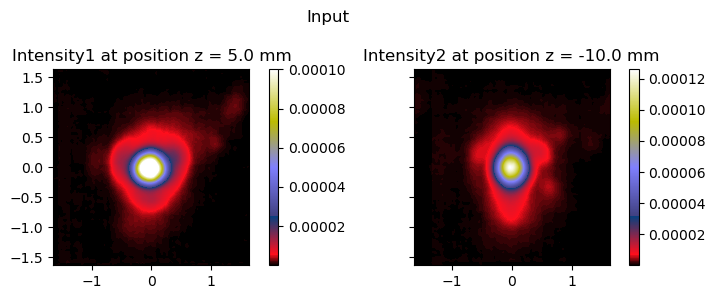

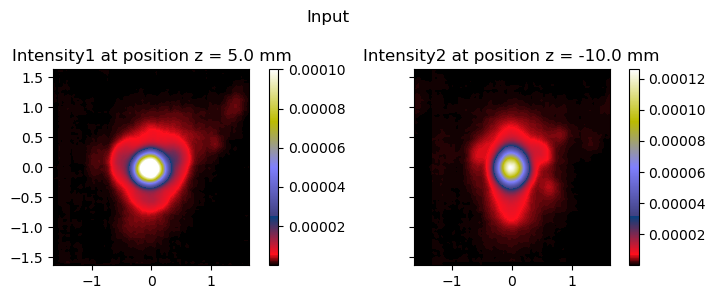

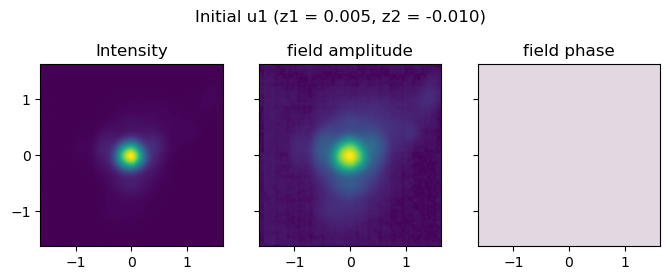

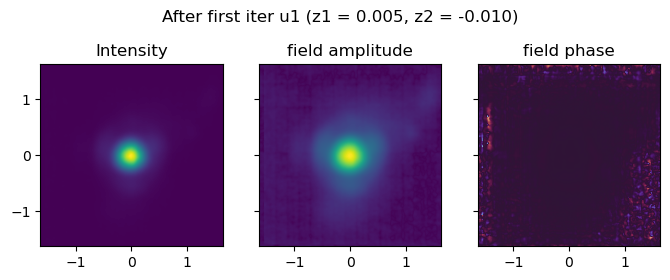

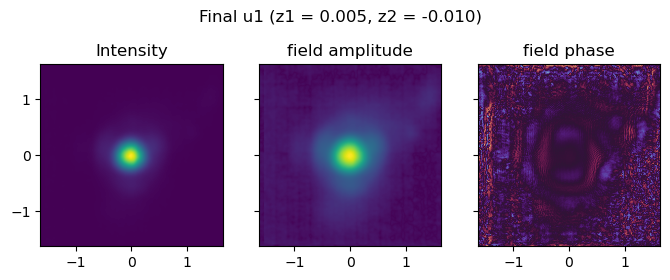

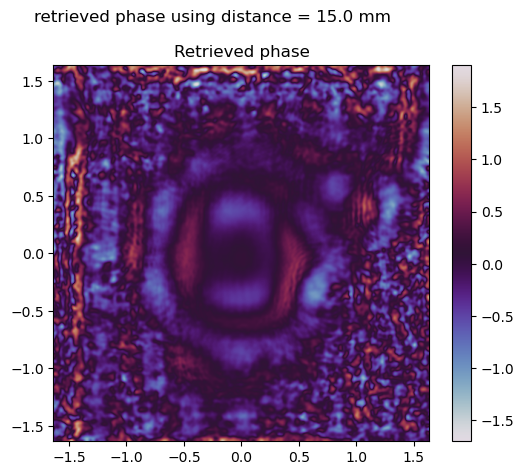

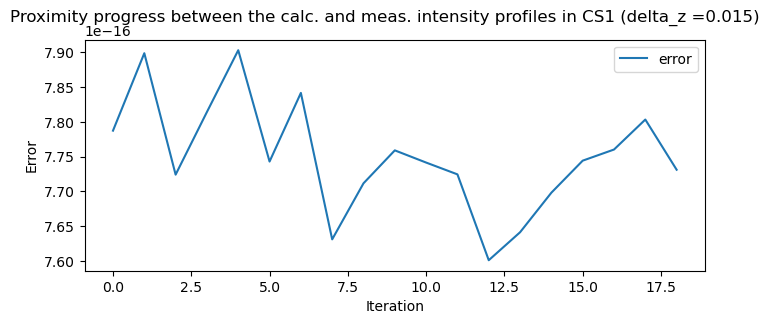

In [62]:
OK = "\033[0;32mOK\033[0;0m"
FAIL = "\033[91mFAIL\033[0;0m"

#Path where the input images are located
base_path = r"C:\Users\orian\OneDrive\Bureau\Stage 2024-25\Pixel method\Oriane\input_images"

def load_data(retriever, path):   
    """Loading data from path
    The image intensity is adjusted (normalization, background subtraction) is done.
    """
    print("Dataset load... ", end="")
    try:
        retriever.load_data(path)
        print(OK)
    except:
        print(FAIL)

def set_values(retriever, pixel_size, wavelength, wavenumber, beam_radius):
    """Sets the parameters of the laser
    """
    print("Pixel size set... ", end="")
    try:
        retriever.config(pixel_size=pixel_size)
        if retriever.options["pixel_size"] != pixel_size:
            raise ValueError()
        print(OK)
    except Exception as e:
        print(FAIL, f"Expected {pixel_size} and got {retriever.options['pixel_size']}")

# Beam
    print("Wavelength set... ", end="")
    try:
        retriever.config(wavelength=wavelength)
        if retriever.options["wavelength"] != wavelength:
            raise ValueError()
        print(OK)
    except:
        print(FAIL, f"Expected {wavelength} and got {retriever.options['wavelength']}")

    print("Wavenumber set... ", end="")
    try:
        retriever.config(wavenumber=wavenumber)
        if retriever.options["wavenumber"] != wavenumber:
            raise ValueError()
        print(OK)
    except:
        print(FAIL, f"Expected {wavenumber} and got {retriever.options['wavenumber']}")

    print("Beam radius set... ", end="")
    try:
        retriever.config(beam_radius=beam_radius)
        if retriever.options["beam_radius"] != beam_radius:
            raise ValueError()
        print(OK)
    except:
        print(FAIL, f"Expected {beam_radius} and got {retriever.options['beam_radius']}")

def test_ideal_lens(crop=False, print_each_iter=False, save_results=False):
    """ Uses the set of images called "foc lent idéale".
    """
    image_set = "foc lent ideale"
    path = os.path.join(base_path, image_set)

    niter = 100
    epsilon = 0 # 4.45e-16
    computer_created = True

    retriever = PhaseRetriever(['0.000', '0.310'], image_set, computer_created, crop, niter, epsilon)
    
    pixel_size = 11.71875e-6
    wavelength = 1064e-9
    wavenumber = 2 * np.pi / wavelength
    beam_radius = 2e-3 / 2
    
    load_data(retriever, path)

    set_values(retriever, pixel_size, wavelength, wavenumber, beam_radius)

    retriever.retrieve_phase(print_each_iter, save_results)

def test_eye_phase(crop=False, print_each_iter=False, save_results=False):
    """Uses the set of images called "phase en oeil".
    """
    image_set = "phase en oeil"
    path = os.path.join(base_path, image_set)

    niter = 200
    epsilon = 0
    computer_created = True

    retriever = PhaseRetriever(['0.000', '0.500'], image_set, computer_created, crop, niter, epsilon)
    
    pixel_size = 11.71875e-6
    wavelength = 1064e-9
    wavenumber = 2 * np.pi / wavelength
    beam_radius = 2e-3 / 2

    load_data(retriever, path)

    set_values(retriever, pixel_size, wavelength, wavenumber, beam_radius)

    retriever.retrieve_phase(print_each_iter, save_results)

def test_real_set_gros_quantel(crop=False, print_each_iter=False, save_results=False):
    """Uses the set of images called "GrosQuantel2024_22_03_355nm".
    """
    image_set = "GrosQuantel2024_22_03_355nm"
    path = os.path.join(base_path, image_set)

    niter = 100
    epsilon = 0
    computer_created = False

    retriever = PhaseRetriever(['0.014', '0.025'], image_set, computer_created, crop, niter, epsilon)

    pixel_size = 11.71875e-6
    wavelength = 3.55e-7
    wavenumber = 2 * np.pi / wavelength
    beam_radius = 2e-3 / 2
    
    load_data(retriever, path)

    set_values(retriever, pixel_size, wavelength, wavenumber, beam_radius)

    retriever.retrieve_phase(print_each_iter, save_results)

def test_smart(crop=False, print_each_iter=False, save_results=False):
    """ Uses the set of images called "Q-smart_2018_03_22_f750mm".
    """
    image_set = "Q-smart_2018_03_22_f750mm"
    path = os.path.join(base_path, image_set)

    niter = 100
    epsilon = 0 # 4.45e-16
    computer_created = True

    retriever = PhaseRetriever(['0.000', '0.310'], image_set, computer_created, crop, niter, epsilon)
    
    pixel_size = 11.71875e-6
    wavelength = 1064e-9
    wavenumber = 2 * np.pi / wavelength
    beam_radius = 2e-3 / 2
    

    load_data(retriever, path)

    set_values(retriever, pixel_size, wavelength, wavenumber, beam_radius)

    retriever.retrieve_phase(print_each_iter, save_results)

def test_real_images(couple_im, crop=False, print_each_iter=False, save_results=False):
    """ Uses the set of images called "images reelle".
    """
    image_set = "images reelle"
    path = os.path.join(base_path, image_set)

    niter = 20
    epsilon = 0 # 4.45e-16
    computer_created = False

    retriever = PhaseRetriever(couple_im, image_set, computer_created, crop, niter, epsilon, real_im=True)
    
    pixel_size = 6.45e-6    #11.71875e-6
    wavelength = 1064e-9
    wavenumber = 2 * np.pi / wavelength
    beam_radius = 2e-3 / 2
    

    load_data(retriever, path)

    set_values(retriever, pixel_size, wavelength, wavenumber, beam_radius)

    retriever.retrieve_phase(print_each_iter, save_results)


list_result = []

test_real_images(['0.005_3', '-0.010_5'], crop=True, print_each_iter=False, save_results=False)
#test_ideal_lens(crop=False, print_each_iter=False, save_results=False)

########
# To test different lenses, or different radius

# test.test_eye_phase(crop=False, print_each_iter=False, save_results=True)
# test.test_real_set_gros_quantel(crop=False, print_each_iter=False, save_results=True)

## Moyenne et variance des résultats

Dataset load... OK
Pixel size set... OK
Wavelength set... OK
Wavenumber set... OK
Beam radius set... OK
*** Execution time: 2.8874 s ***
### CONFIGURATION ###
Image set: images reelle
Maximum number of iterations: 20
Epsilon: 0
Pixel size: 6.45e-06
Shape: (508, 508)
Wavelength: 1.064e-06
Distance z1: 0.005
Distance z2: -0.010
Distance between the two planes: 0.015
### OTHERS ###
Origin of the region with highest intensity at z1: [253, 254]
Origin of the region with highest intensity at z2: [254, 255]
Mask shape: (507, 507)
Cropped: True
Min relevant intensity value: 1e-05
### RESULTS ###
Objective Function value: 9.077485287512973e-07
Final number of iterations: 20


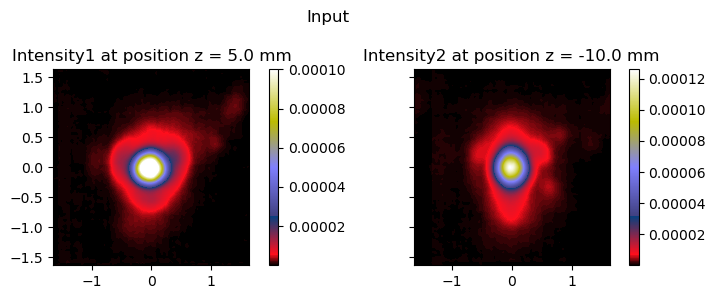

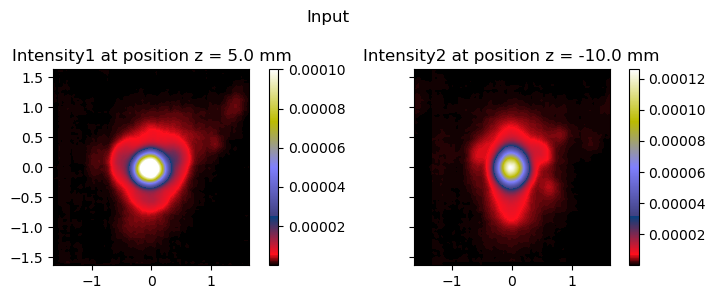

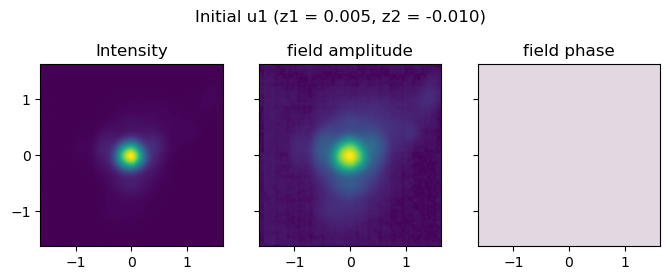

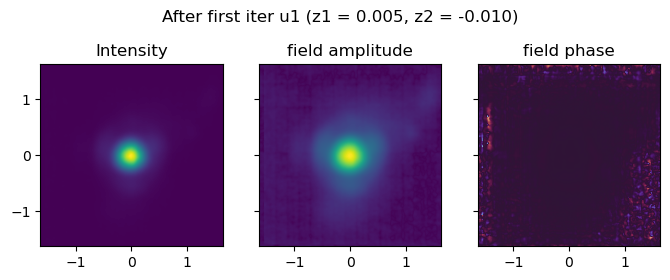

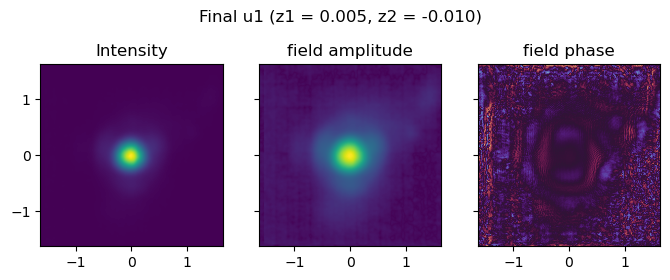

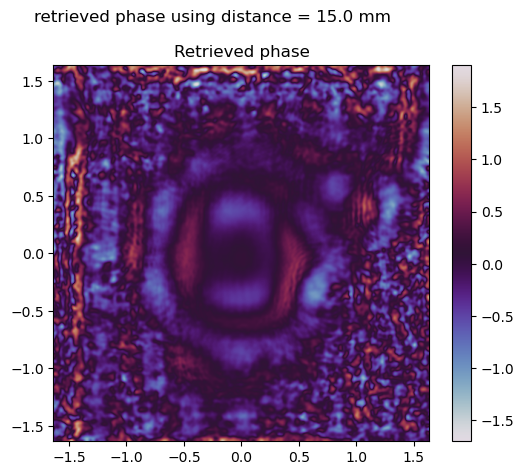

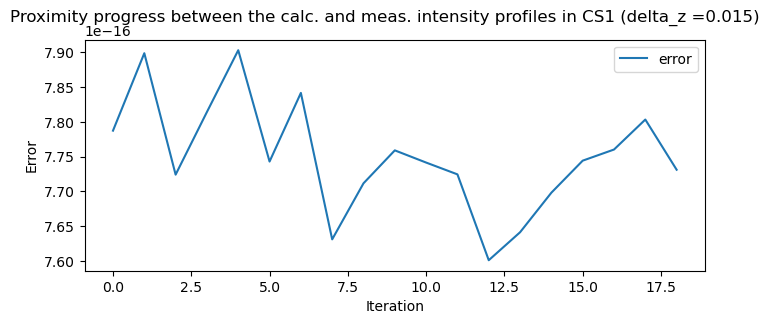

Dataset load... OK
Pixel size set... OK
Wavelength set... OK
Wavenumber set... OK
Beam radius set... OK
*** Execution time: 2.4048 s ***
### CONFIGURATION ###
Image set: images reelle
Maximum number of iterations: 20
Epsilon: 0
Pixel size: 6.45e-06
Shape: (508, 508)
Wavelength: 1.064e-06
Distance z1: 0.005
Distance z2: -0.010
Distance between the two planes: 0.015
### OTHERS ###
Origin of the region with highest intensity at z1: [253, 255]
Origin of the region with highest intensity at z2: [254, 255]
Mask shape: (507, 507)
Cropped: True
Min relevant intensity value: 1e-05
### RESULTS ###
Objective Function value: 9.057929114824081e-07
Final number of iterations: 20


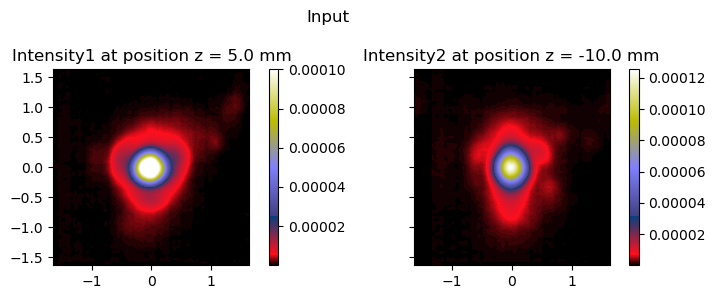

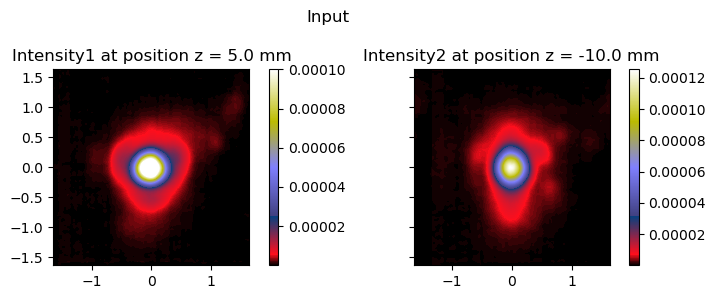

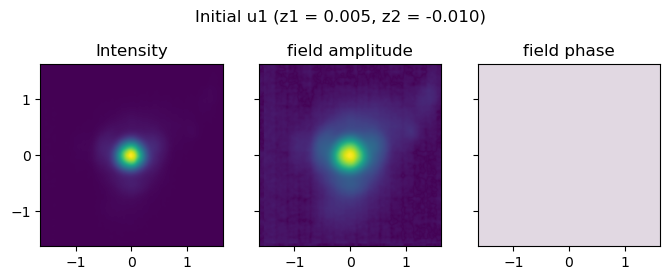

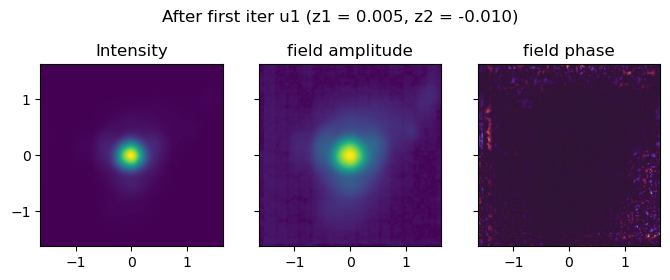

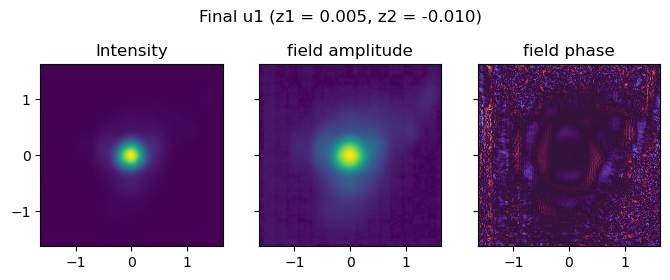

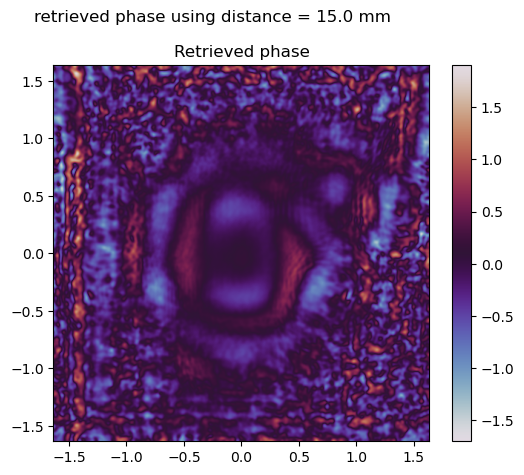

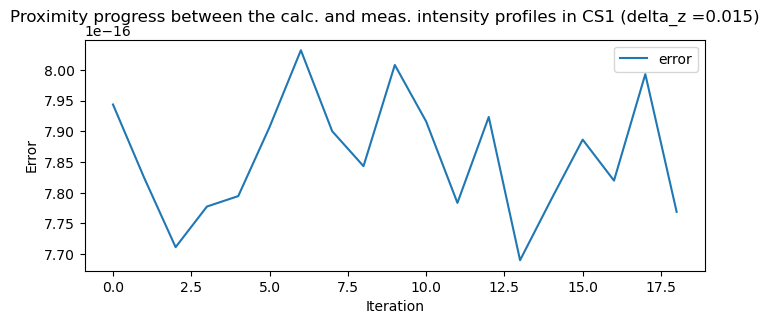

Dataset load... OK
Pixel size set... OK
Wavelength set... OK
Wavenumber set... OK
Beam radius set... OK
*** Execution time: 2.2752 s ***
### CONFIGURATION ###
Image set: images reelle
Maximum number of iterations: 20
Epsilon: 0
Pixel size: 6.45e-06
Shape: (508, 508)
Wavelength: 1.064e-06
Distance z1: 0.005
Distance z2: -0.010
Distance between the two planes: 0.015
### OTHERS ###
Origin of the region with highest intensity at z1: [253, 255]
Origin of the region with highest intensity at z2: [253, 254]
Mask shape: (507, 507)
Cropped: True
Min relevant intensity value: 1e-05
### RESULTS ###
Objective Function value: 9.859203453466683e-07
Final number of iterations: 20


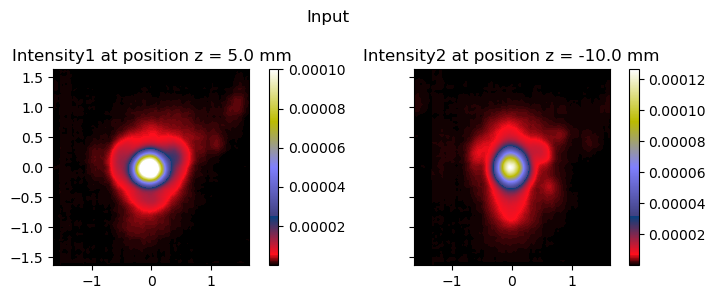

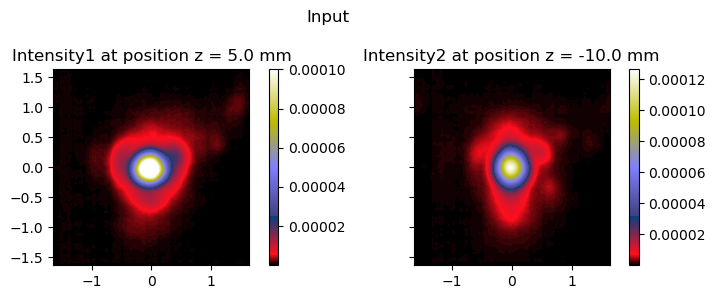

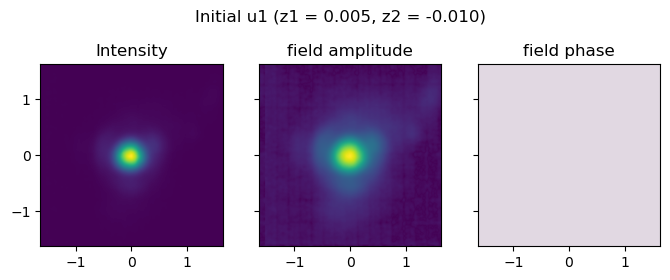

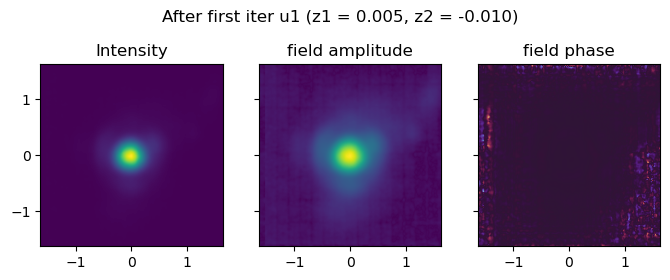

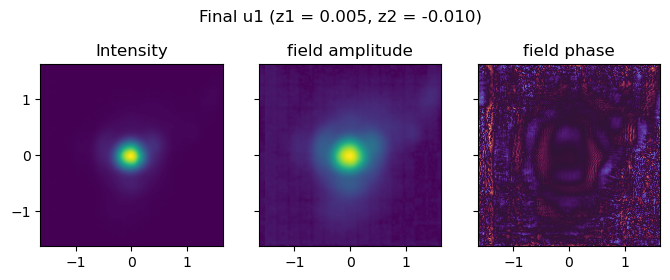

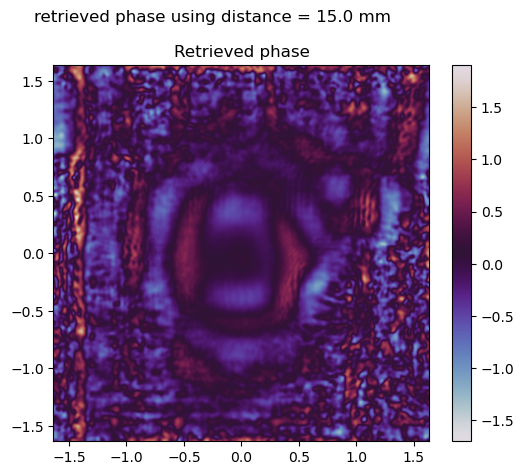

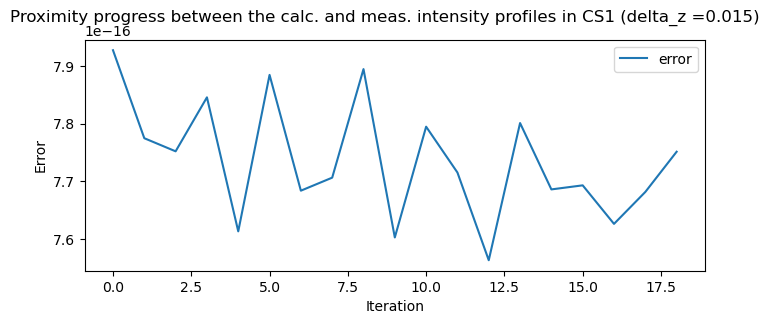

Dataset load... OK
Pixel size set... OK
Wavelength set... OK
Wavenumber set... OK
Beam radius set... OK
*** Execution time: 2.132 s ***
### CONFIGURATION ###
Image set: images reelle
Maximum number of iterations: 20
Epsilon: 0
Pixel size: 6.45e-06
Shape: (508, 508)
Wavelength: 1.064e-06
Distance z1: 0.005
Distance z2: -0.010
Distance between the two planes: 0.015
### OTHERS ###
Origin of the region with highest intensity at z1: [253, 254]
Origin of the region with highest intensity at z2: [253, 255]
Mask shape: (507, 507)
Cropped: True
Min relevant intensity value: 1e-05
### RESULTS ###
Objective Function value: 9.689007061526285e-07
Final number of iterations: 20


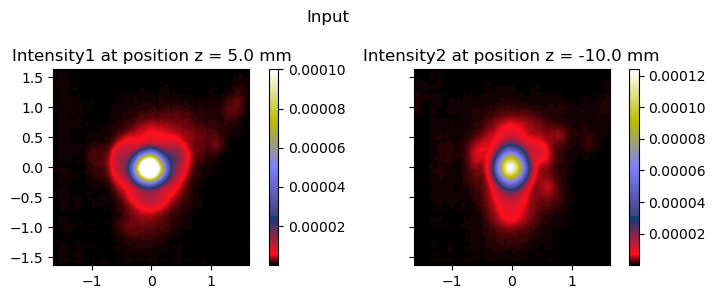

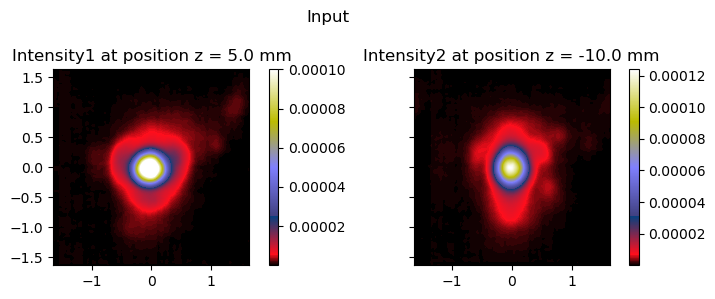

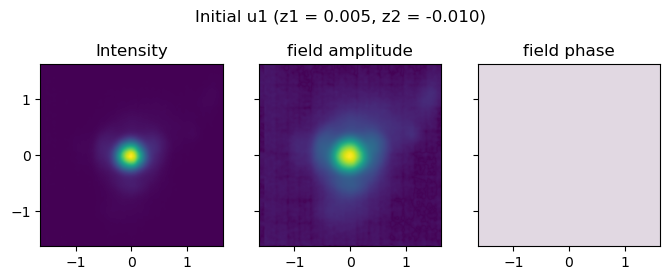

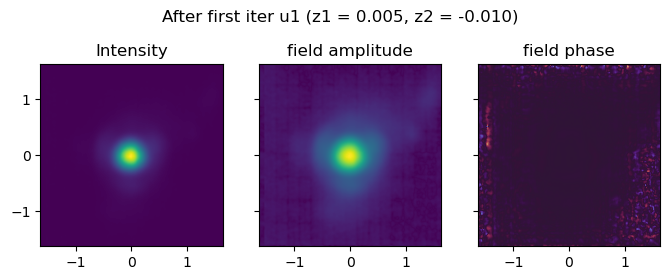

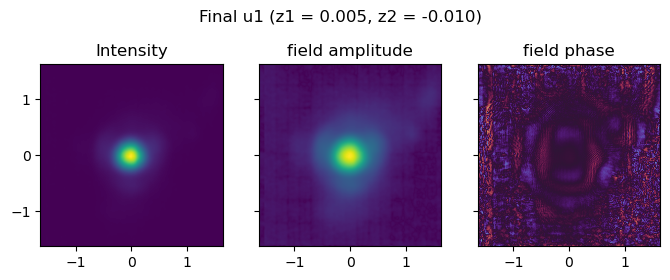

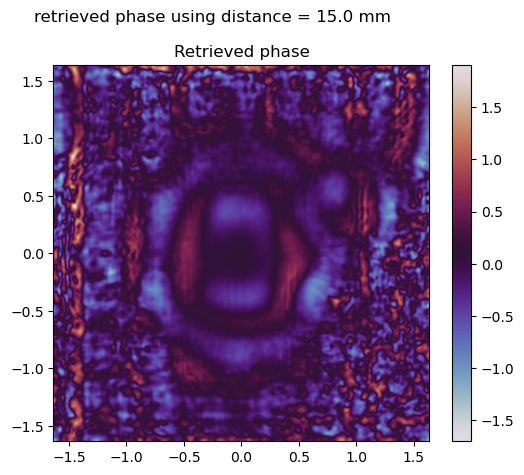

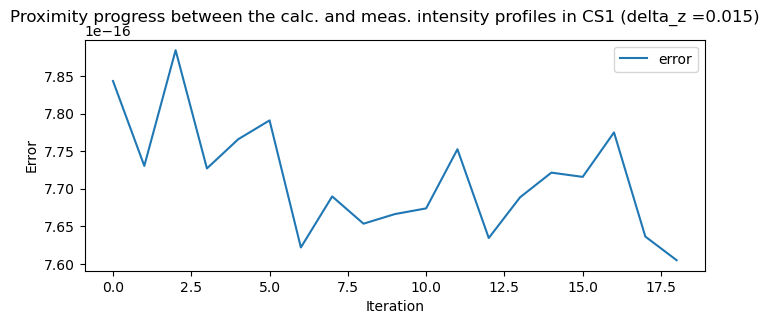

Dataset load... OK
Pixel size set... OK
Wavelength set... OK
Wavenumber set... OK
Beam radius set... OK
*** Execution time: 2.3155 s ***
### CONFIGURATION ###
Image set: images reelle
Maximum number of iterations: 20
Epsilon: 0
Pixel size: 6.45e-06
Shape: (508, 508)
Wavelength: 1.064e-06
Distance z1: 0.005
Distance z2: -0.010
Distance between the two planes: 0.015
### OTHERS ###
Origin of the region with highest intensity at z1: [253, 254]
Origin of the region with highest intensity at z2: [254, 255]
Mask shape: (507, 507)
Cropped: True
Min relevant intensity value: 1e-05
### RESULTS ###
Objective Function value: 9.477255063937349e-07
Final number of iterations: 20


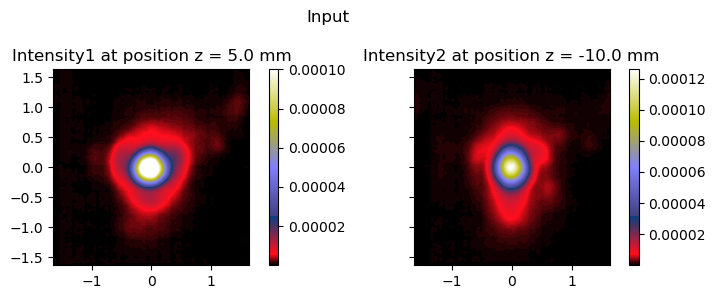

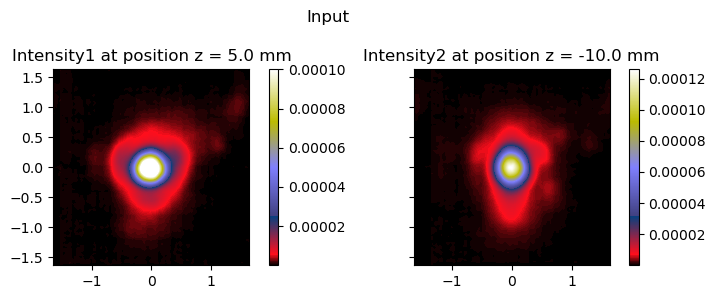

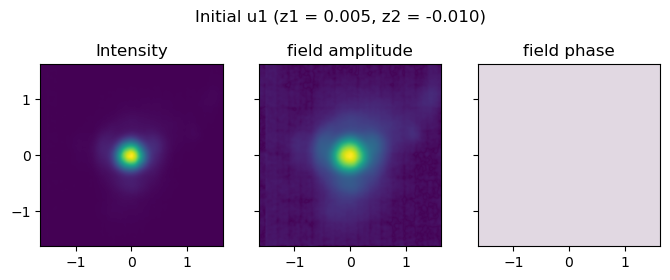

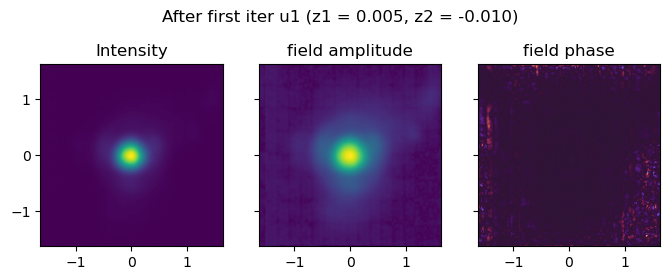

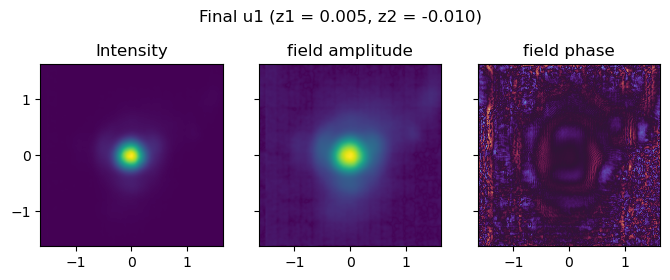

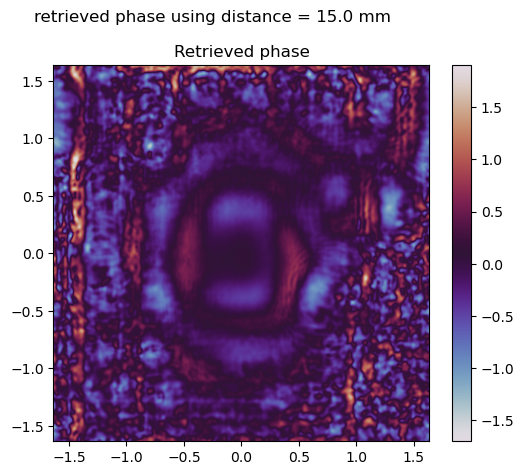

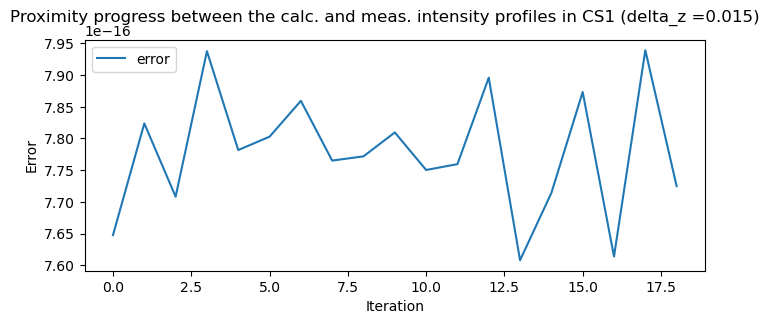

"\nplt.figure('esm')\nplt.suptitle('ESM')\nplt.imshow(esm, cmap='viridis')\nplt.colorbar()\n"

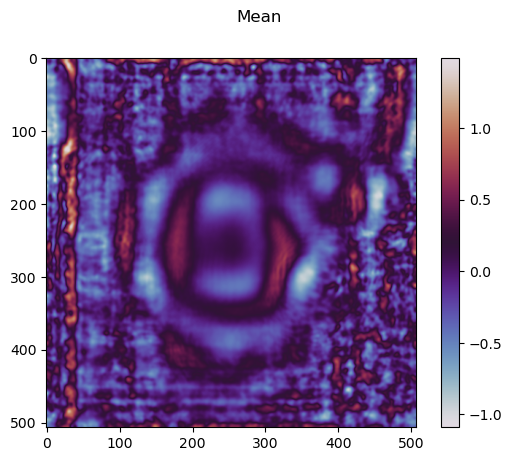

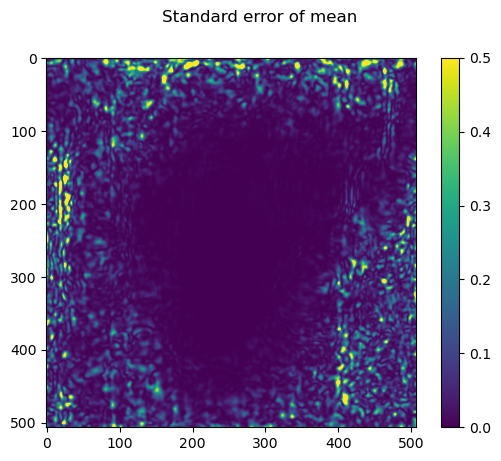

In [63]:
list_image = [['0.005_3', '-0.010_5'], ['0.005_6', '-0.010_7'], ['0.005_8', '-0.010_8'], ['0.005_11', '-0.010_11'],  ['0.005_13', '-0.010_14']]
list_result = []
for element in list_image :
    test_real_images(element, crop=True, print_each_iter=False, save_results=False)
moyenne = (np.array(list_result).sum(axis=0)) / len(list_result)
variance = 0
ecarttype = 0
for element in list_result:
    ecarttype += (element-moyenne)
    variance += ecarttype**2
esm = ecarttype/moyenne
variance = variance/len(list_result)

plt.figure('moyenne')
plt.suptitle('Mean')
plt.imshow(moyenne, cmap='twilight')
plt.colorbar()

plt.figure('variance')
plt.suptitle('Standard error of mean')
plt.imshow(variance, cmap='viridis',vmin=0,vmax=0.5)
plt.colorbar()

"""
plt.figure('esm')
plt.suptitle('ESM')
plt.imshow(esm, cmap='viridis')
plt.colorbar()
"""

# 6 The maximmal spatial frequency

Il existe duex méthodes pour retrouver la fréquence maximum: analytique et numérique

analytique:




## Pour deux sources en y différent
D'après la littérature on a comme période de phase $\Delta x' = \frac{\lambda L}{D}$ et donc on pour fréquence spatiale : $f_s = \frac{\Delta x'}{\lambda L} = \frac{1}{D}$.
En prenant la distance entre les deux sources $D=512*1,171875.10^{-5}$, on obtient alors une fréquence spatiale de $f_s=166,667 cy/m$

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftfreq

pisi = 11.71875e-6  # pixel size in meters
la = 1064e-9  # wavelength in meters
k = 2 * np.pi / la
taille = 512 # in pixels

#axes en mètes
y_extend = (taille) * pisi # in meters
x_extend = (taille) * pisi # in meters
#axes centrés en 0,0
y_pts = np.linspace(-y_extend/2, y_extend/2, num=taille) # in meters
x_pts = np.linspace(-x_extend/2, x_extend/2, num=taille) # in meters
#matrice des axes
X, Y = np.meshgrid(x_pts, y_pts)

On peut aussi calculer cette fréquence spatiale numériquement avec le code suivant:

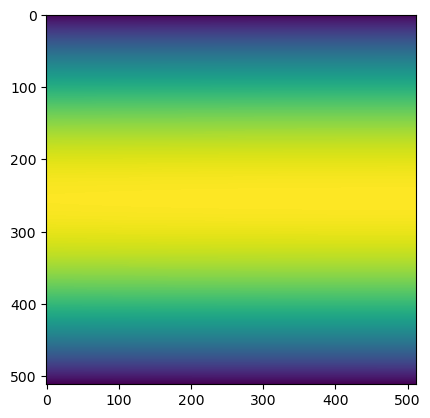

In [29]:
source = np.zeros((taille,taille))
I1 = 1
I2 = 1
x1 = taille//2
x2 = taille//2
y1 = 0
y2 = -1
source[y1,x1] = I1
source[y2,x2] = I2

#focale de notre lentille
f=0.31      #en mètre
#Distance source/écran
d=f     #en mètre

r1 = np.sqrt(d**2 + abs(X - x1*pisi)**2 + abs(Y - y1*pisi)**2)
r2 = np.sqrt(d**2 + abs(X - x2*pisi)**2 + abs(Y - y2*pisi)**2)
ecran = np.sqrt(I1)*np.exp(1j*k*r1)/r1 + np.sqrt(I2)*np.exp(1j*k * r2)/r2
plt.figure('ecran')
plt.imshow(np.abs(ecran**2))

On peut alors compter 1 franges lumineuses sur une largeur de 512 pixels. La fréquence spatiales vaut alors $f_s = \frac{1}{512} = 1,95.10^{-3}cy/pixel$ ou alors $f_s = \frac{1}{512 * 1.171875.10^{-5}} = 166,67 cy/pixel$


## Pour deux sources à deux coins extremes

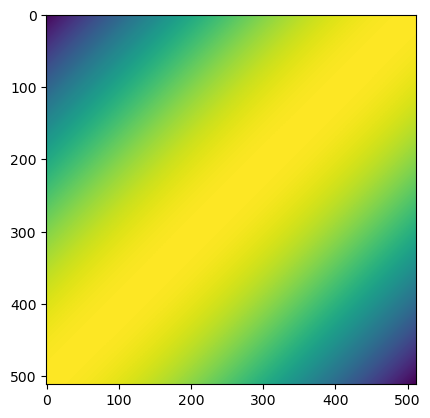

In [30]:
source = np.zeros((taille,taille))
I1 = 1
I2 = 1
x1 = 0
x2 = -1
y1 = 0
y2 = -1
source[y1,x1] = I1
source[y2,x2] = I2

#focale de notre lentille
f=0.31      #en mètre
#Distance source/écran
d=f     #en mètre

r1 = np.sqrt(d**2 + abs(X - x1*pisi)**2 + abs(Y - y1*pisi)**2)
r2 = np.sqrt(d**2 + abs(X - x2*pisi)**2 + abs(Y - y2*pisi)**2)
ecran = np.sqrt(I1)*np.exp(1j*k*r1)/r1 + np.sqrt(I2)*np.exp(1j*k * r2)/r2
plt.figure('ecran')
plt.imshow(np.abs(ecran**2))

On peut alors compter une frange sur une largeur de $\sqrt{2*512**2} = 724,08$ pixels. Cela nous donne une fréquence spatiale de 117,85Hz